<a id="seccion-1"></a>

<h1 style="text-align: center; font-size: 70px; font-weight: 500;">Análisis de Indicadores: Sistema ETC Automatizado</h1>

- Autor: José Guillermo Sepúlveda Salazar.
- Practicante, Unidad de Estadística, UFRO, 2024.

<a id="seccion-2"></a>

## **Descripción**
Este documento detalla un enfoque metodológico sistemático destinado a la automatización de indicadores, que se extiende desde la adquisición de datos en línea hasta su cálculo y almacenamiento subsiguiente en Sistemas de Gestión de Bases de Datos (SGBD). Se ha implementado un marco metodológico que incluye una estructura de validación robusta para la extracción de archivos, garantizando su correcta integración en el repositorio designado. Además, realiza una verificación dentro del SGBD para asegurar la actualización de los indicadores correspondientes al año 2023.

Con el objetivo de reforzar la seguridad y asegurar la confidencialidad de los datos, el sistema incorpora mecanismos de autenticación avanzados. Esta estrategia no solo optimiza la eficiencia en la gestión de indicadores, sino que también protege la integridad de la información confidencial, cumpliendo así con los estándares de seguridad necesarios para el manejo de datos sensibles.

El proceso de automatización se estructura en tres fases fundamentales: extracción, transformación y carga (ETC). Durante la fase de extracción, el sistema verifica la presencia de la base de datos en el repositorio. En caso de no encontrarse, se procede a realizar una extracción de datos mediante técnicas de Web Scraping o conexiones API, lo que incluye la descarga y asignación de nombres a los archivos correspondientes. En la etapa de transformación, se llevan a cabo análisis estadísticos sobre cada indicador susceptible de actualización, lo que permite obtener resultados renovados. Finalmente, en la etapa de carga, el sistema se conecta al SGBD mediante credenciales de acceso específicas y verifica la actualización de los indicadores mediante la búsqueda del año correspondiente. Si los indicadores no están actualizados, se procede a la carga de los datos previamente transformados.

<a id="indice"></a>

## **Índice**
- [Portada](#seccion-1)
- [Descripción](#seccion-2)

- [I) Extracción](#seccion-4)
    - [Obtenemos la BD de la oferta académica en el sistema de educación superior historica 2010-2024 de miFuturo.](#subseccion-4-1)
    - [Obtenemos la BD de estudiantes matriculados en educación superior historica 2007-2023 de miFuturo.](#subseccion-4-2)
    - [Obtenemos la BD del personal académico del sistema de educación superior año 2023 de miFuturo.](#subseccion-4-3)
    
- [II) Transformación](#seccion-5)
    - [1. Cantidad de programas de magíster y doctorado ofrecidos por universidades según región de sede (excluyendo la Región Metropolitana.](#subseccion-5-1)
        - [Grafica del indicador 1](#subseccion-5-1-1)
    - [2. Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](#subseccion-5-2)
        - [Grafica del indicador 2](#subseccion-5-2-1)
    - [3. Evolución anual de la cantidad de programas de postgrado ofrecidos por universidades en Chile, según región de sede.](#subseccion-5-3)
        - [Grafica del indicador 3](#subseccion-5-3-1)
    - [4. Cantidad de programas de postgrado en áreas STEM por región de sede.](#subseccion-5-4)
        - [Grafica del indicador 4](#subseccion-5-4-1)
    - [5. Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](#subseccion-5-5)
        - [Grafica del indicador 5](#subseccion-5-5-1)
    - [6. Distribución de matrículas de pregrado, magíster y doctorado según sexo.](#subseccion-5-6)
        - [Grafica del indicador 6](#subseccion-5-6-1)
    - [7. Distribución de personas matriculadas en pregrado según sexo por campo de educación.](#subseccion-5-7)
        - [Grafica del indicador 7](#subseccion-5-7-1)
    - [8. Distribución del personal académico de las instituciones de educación superior según sexo.](#subseccion-5-8)
        - [Grafica del indicador 8](#subseccion-5-8-1)

- [III) Carga](#seccion-6)
    - [1. Cantidad de programas de magíster y doctorado ofrecidos por universidades según región de sede (excluyendo la Región Metropolitana.](#subseccion-6-1)
    - [2. Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](#subseccion-6-2)
    - [3. Evolución anual de la cantidad de programas de postgrado ofrecidos por universidades en Chile, según región de sede.](#subseccion-6-3)
    - [4. Cantidad de programas de postgrado en áreas STEM por región de sede.](#subseccion-6-4)
    - [5. Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](#subseccion-6-5)
    - [6. Distribución de matrículas de pregrado, magíster y doctorado según sexo.](#subseccion-6-6)
    - [7. Distribución de personas matriculadas en pregrado según sexo por campo de educación.](#subseccion-6-7)
    - [8. Distribución del personal académico de las instituciones de educación superior según sexo.](#subseccion-6-8)

In [1]:
# Importamos las librerias necesarias
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
from selenium import webdriver
import pandas as pd
import configparser
import numpy as np
import openpyxl
import psycopg2
import zipfile
import time
import os

<a id="seccion-4"></a>

# **I) Extracción**

[Volver al índice](#indice)

<a id="subseccion-4-1"></a>

## [Obtenemos la BD de la oferta académica en el sistema de educación superior historica 2010-2024 de miFuturo.](https://www.mifuturo.cl/bases-de-datos-de-oferta-academica/)

[Volver al índice](#indice)

In [2]:
def esperar_descarga_completa(directorio, extension, timeout=300):
    tiempo_inicio = time.time()
    while True:
        archivos_temporales = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.crdownload') or archivo.endswith('.part')]
        if not archivos_temporales:
            # Espera un momento después de que desaparezcan los archivos temporales para asegurar que la descarga ha finalizado
            time.sleep(1)
            archivos = [archivo for archivo in os.listdir(directorio) if archivo.endswith(extension)]
            if archivos:
                return os.path.join(directorio, archivos[-1])  # Retorna el último archivo descargado con la extensión deseada
        elif (time.time() - tiempo_inicio) > timeout:
            raise Exception("Tiempo de espera para la finalización de la descarga excedido.")
        time.sleep(1)

# Función para obtener el último archivo descargado
def obtener_ultimo_archivo_descargado(directorio):
    lista_de_archivos = os.listdir(directorio)
    rutas_completas = [os.path.join(directorio, archivo) for archivo in lista_de_archivos]
    archivo_mas_reciente = max(rutas_completas, key=os.path.getmtime)
    return archivo_mas_reciente

nombre_del_archivo = "OFERTA_SIES_2010_AL_2024.csv"         # Nombre del archivo a buscar
carpeta = os.getcwd()                                       # Utiliza el directorio actual de trabajo como carpeta de búsqueda
ruta_completa = os.path.join(carpeta, nombre_del_archivo)   # Construcción de la ruta del archivo

# Verificar si el archivo existe en la carpeta
if os.path.isfile(ruta_completa):
    print(f"El archivo '{nombre_del_archivo}' está presente en el directorio actual.")
else:
    print(f"El archivo '{nombre_del_archivo}' no se encontró en el directorio actual.")
    print("Procedemos al Scraping para obtener el descargable.")
    # Configurar opciones de Selenium y Chrome
    options = webdriver.ChromeOptions()

    # Especificar la carpeta de descarga como el directorio actual de trabajo
    current_directory = os.getcwd()
    prefs = {"download.default_directory": current_directory}
    options.add_experimental_option("prefs", prefs)

    # Inicializar el WebDriver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    # Acceder a la página web
    url = "https://www.mifuturo.cl/bases-de-datos-de-oferta-academica/"
    driver.get(url)

    WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.TAG_NAME, "body")))       # Carga la página
    time.sleep(1)
    Click = WebDriverWait(driver, 0).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "body > div > div > div:nth-child(7) > div.col-md-8.text-justify.col-content > div:nth-child(4) > div > p:nth-child(3) > a"))).click()
    time.sleep(1)
    # Esperar a que la descarga se complete
    ruta_archivo_descargado = esperar_descarga_completa(carpeta, '.zip')
    driver.quit()                                                                               # Cierra el navegador

    ultimo_archivo_descargado = obtener_ultimo_archivo_descargado(current_directory)            # Obtener el último archivo descargado
    print("Zip Descargado")
    # Extraer el contenido del archivo zip y renombrar el CSV
    with zipfile.ZipFile(ultimo_archivo_descargado, 'r') as archivo_zip:
        for miembro_zip in archivo_zip.namelist():
            if miembro_zip.endswith('.csv'):
                archivo_zip.extract(miembro_zip, carpeta)
                print("archivo descomprimido")
                # Renombrar el archivo CSV
                os.rename(os.path.join(carpeta, miembro_zip), os.path.join(carpeta, nombre_del_archivo))
                print(f"El archivo '{miembro_zip}' ha sido renombrado a '{nombre_del_archivo}'.")
                break 

    # Eliminar el archivo zip después de la extracción
    os.remove(ultimo_archivo_descargado)    
    print("carpeta zip eliminada")
   
    print("Descarga, extracción y renombrado completado")

El archivo 'OFERTA_SIES_2010_AL_2024.csv' está presente en el directorio actual.


<a id="subseccion-4-2"></a>

## [Obtenemos la BD de estudiantes matriculados en educación superior historica 2007-2023 de miFuturo.](https://www.mifuturo.cl/bases-de-datos-de-matriculados/)

[Volver al índice](#indice)

In [3]:
def esperar_descarga_completa(directorio, extension, timeout=300):
    tiempo_inicio = time.time()
    while True:
        archivos_temporales = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.crdownload') or archivo.endswith('.part')]
        if not archivos_temporales:
            # Espera un momento después de que desaparezcan los archivos temporales para asegurar que la descarga ha finalizado
            time.sleep(1)
            archivos = [archivo for archivo in os.listdir(directorio) if archivo.endswith(extension)]
            if archivos:
                return os.path.join(directorio, archivos[-1])  # Retorna el último archivo descargado con la extensión deseada
        elif (time.time() - tiempo_inicio) > timeout:
            raise Exception("Tiempo de espera para la finalización de la descarga excedido.")
        time.sleep(1)

# Función para obtener el último archivo descargado
def obtener_ultimo_archivo_descargado(directorio):
    lista_de_archivos = os.listdir(directorio)
    rutas_completas = [os.path.join(directorio, archivo) for archivo in lista_de_archivos]
    archivo_mas_reciente = max(rutas_completas, key=os.path.getmtime)
    return archivo_mas_reciente

nombre_del_archivo = "MATRICULA_SIES_ 2007_AL_2023.csv"     # Nombre del archivo a buscar
carpeta = os.getcwd()                                       # Utiliza el directorio actual de trabajo como carpeta de búsqueda
ruta_completa = os.path.join(carpeta, nombre_del_archivo)   # Construcción de la ruta del archivo

# Verificar si el archivo existe en la carpeta
if os.path.isfile(ruta_completa):
    print(f"El archivo '{nombre_del_archivo}' está presente en el directorio actual.")
else:
    print(f"El archivo '{nombre_del_archivo}' no se encontró en el directorio actual.")
    print("Procedemos al Scraping para obtener el descargable.")
    # Configurar opciones de Selenium y Chrome
    options = webdriver.ChromeOptions()

    # Especificar la carpeta de descarga como el directorio actual de trabajo
    current_directory = os.getcwd()
    prefs = {"download.default_directory": current_directory}
    options.add_experimental_option("prefs", prefs)

    # Inicializar el WebDriver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    # Acceder a la página web
    url = "https://www.mifuturo.cl/bases-de-datos-de-matriculados/"
    driver.get(url)

    WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.TAG_NAME, "body")))       # Carga la página
    time.sleep(1)
    Click = WebDriverWait(driver, 0).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "body > div > div > div:nth-child(7) > div.col-md-8.text-justify.col-content > div:nth-child(4) > div > p:nth-child(3) > a"))).click()
    time.sleep(1)
    # Esperar a que la descarga se complete
    ruta_archivo_descargado = esperar_descarga_completa(carpeta, '.zip')
    driver.quit()                                                                               # Cierra el navegador

    ultimo_archivo_descargado = obtener_ultimo_archivo_descargado(current_directory)            # Obtener el último archivo descargado
    print("Zip Descargado")
    # Extraer el contenido del archivo zip y renombrar el CSV
    with zipfile.ZipFile(ultimo_archivo_descargado, 'r') as archivo_zip:
        for miembro_zip in archivo_zip.namelist():
            if miembro_zip.endswith('.csv'):
                archivo_zip.extract(miembro_zip, carpeta)
                print("archivo descomprimido")
                # Renombrar el archivo CSV
                os.rename(os.path.join(carpeta, miembro_zip), os.path.join(carpeta, nombre_del_archivo))
                print(f"El archivo '{miembro_zip}' ha sido renombrado a '{nombre_del_archivo}'.")
                break 

    # Eliminar el archivo zip después de la extracción
    os.remove(ultimo_archivo_descargado)    
    print("carpeta zip eliminada")
   
    print("Descarga, extracción y renombrado completado")

El archivo 'MATRICULA_SIES_ 2007_AL_2023.csv' está presente en el directorio actual.


<a id="subseccion-4-3"></a>

## [Obtenemos la BD del personal académico del sistema de educación superior año 2023 de miFuturo.](https://www.mifuturo.cl/bases-de-datos-personal-academico/)

[Volver al índice](#indice)

In [4]:
def esperar_descarga_completa(directorio, extension, timeout=300):
    tiempo_inicio = time.time()
    while True:
        archivos_temporales = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.crdownload') or archivo.endswith('.part')]
        if not archivos_temporales:
            # Espera un momento después de que desaparezcan los archivos temporales para asegurar que la descarga ha finalizado
            time.sleep(1)
            archivos = [archivo for archivo in os.listdir(directorio) if archivo.endswith(extension)]
            if archivos:
                return os.path.join(directorio, archivos[-1])  # Retorna el último archivo descargado con la extensión deseada
        elif (time.time() - tiempo_inicio) > timeout:
            raise Exception("Tiempo de espera para la finalización de la descarga excedido.")
        time.sleep(1)

# Función para obtener el último archivo descargado
def obtener_ultimo_archivo_descargado(directorio):
    lista_de_archivos = os.listdir(directorio)
    rutas_completas = [os.path.join(directorio, archivo) for archivo in lista_de_archivos]
    archivo_mas_reciente = max(rutas_completas, key=os.path.getmtime)
    return archivo_mas_reciente

nombre_del_archivo = "Personal_Academico_SIES_2023.xlsx"    # Nombre del archivo a buscar
carpeta = os.getcwd()                                       # Utiliza el directorio actual de trabajo como carpeta de búsqueda
ruta_completa = os.path.join(carpeta, nombre_del_archivo)   # Construcción de la ruta del archivo

# Verificar si el archivo existe en la carpeta
if os.path.isfile(ruta_completa):
    print(f"El archivo '{nombre_del_archivo}' está presente en el directorio actual.")
else:
    print(f"El archivo '{nombre_del_archivo}' no se encontró en el directorio actual.")
    print("Procedemos al Scraping para obtener el descargable.")
    # Configurar opciones de Selenium y Chrome
    options = webdriver.ChromeOptions()

    # Especificar la carpeta de descarga como el directorio actual de trabajo
    current_directory = os.getcwd()
    prefs = {"download.default_directory": current_directory}
    options.add_experimental_option("prefs", prefs)

    # Inicializar el WebDriver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    # Acceder a la página web
    url = "https://www.mifuturo.cl/bases-de-datos-personal-academico/"
    driver.get(url)

    WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.TAG_NAME, "body")))       # Carga la página
    time.sleep(1)
    Click = WebDriverWait(driver, 0).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "body > div > div > div:nth-child(7) > div.col-md-8.text-justify.col-content > div:nth-child(4) > div > p:nth-child(2) > a"))).click()
    time.sleep(1)
    # Esperar a que la descarga se complete
    ruta_archivo_descargado = esperar_descarga_completa(carpeta, '.xlsx')                                                                              # espera que el archivo se descargue
    driver.quit()                                                                               # Cierra el navegador
    
    ultimo_archivo_descargado = obtener_ultimo_archivo_descargado(current_directory)            # Obtener el último archivo descargado
    os.rename(ultimo_archivo_descargado, os.path.join(current_directory, nombre_del_archivo))   # Renombrar el último archivo descargado
    print("Descarga y renombrado completo.")

El archivo 'Personal_Academico_SIES_2023.xlsx' está presente en el directorio actual.


<a id="seccion-5"></a>

# **II) Transformación**

[Volver al índice](#indice) 

<a id="subseccion-5-2"></a>

## 2. **[Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-matricula-pregrado-magister-y-doctorado-en-universidades-en-chile)**

 * **Archivo**: MATRICULA_SIES_ 2007_AL_2023.csv
 * **Descripción**: En esta sección, se realiza la carga de un archivo CSV para convertirlo en un DataFrame. Posteriormente, se aplica un filtro para el año 2023. Mediante el uso de NumPy, se añade una columna adicional llamada "AUX_NIVEL" al DataFrame. Esta nueva columna se categoriza en base a los valores de "CARRERA CLASIFICACIÓN NIVEL 2". Finalmente, se exhiben los resultados obtenidos a través de la consola. Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice)   

In [40]:
# Leer el archivo CSV en un DataFrame de pandas
df_matricula = pd.read_csv("MATRICULA_SIES_ 2007_AL_2023.csv", encoding='ISO-8859-1', sep=';', low_memory=False) 

# Filtra los datos para el año 2023
df_filtrado = df_matricula[(df_matricula['AÑO'] == 'MAT_2023')]

# Define las columnas relevantes según los parámetros proporcionados sin el parámetro año
columnas_relevantes = [
    'TOTAL MATRICULADOS', 'MATRICULADOS MUJERES POR PROGRAMA',
    'MATRICULADOS HOMBRES POR PROGRAMA', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1',
    'CLASIFICACIÓN INSTITUCIÓN NIVEL 2', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 3',
    'REGIÓN', 'NOMBRE CARRERA', 'ÁREA DEL CONOCIMIENTO', 'CINE-F 1997 ÁREA',
    'CINE-F 1997 SUBAREA', 'ÁREA CARRERA GENÉRICA', 'CINE-F 2013 ÁREA',
    'CINE-F 2013 SUBAREA', 'NIVEL GLOBAL', 'CARRERA CLASIFICACIÓN NIVEL 1',
    'CARRERA CLASIFICACIÓN NIVEL 2'
]

# Asegurarse de que df_matricula es una copia independiente
df_matricula = df_filtrado[columnas_relevantes].copy()

# Definir las condiciones
condiciones = [
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'].isin(['Carreras Profesionales', 'Carreras Técnicas']),
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Magister',
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Doctorado',
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Postítulo'
]

# Definir las elecciones correspondientes a cada condición
elecciones = [
    'Pregrado',
    'Magister',
    'Doctorado',
    'No aplica'
]

# Crear la nueva columna 'AUX_NIVEL' con np.select
df_matricula['AUX_NIVEL'] = np.select(condiciones, elecciones, default='Otro')

In [41]:
# creamos una variable nueva para que no se modifique el df de carga al usar ploteos
df_matricula_carga = df_matricula

In [42]:
# Obtener los primeros 5 resultados de df_matricula
df_matricula_ensayo = df_matricula.head()

# Mostrar los primeros 5 resultados
print(df_matricula_ensayo)
print(f'[{df_matricula.shape[0]} registros x {df_matricula.shape[1]} columnas]')

   TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA  \
0                  52                               20.0   
1                 367                              228.0   
2                  92                               70.0   
3                 452                              371.0   
4                   4                                NaN   

   MATRICULADOS HOMBRES POR PROGRAMA CLASIFICACIÓN INSTITUCIÓN NIVEL 1  \
0                               32.0                     Universidades   
1                              139.0                     Universidades   
2                               22.0                     Universidades   
3                               81.0                     Universidades   
4                                4.0                     Universidades   

  CLASIFICACIÓN INSTITUCIÓN NIVEL 2 CLASIFICACIÓN INSTITUCIÓN NIVEL 3  \
0            Universidades Privadas            Universidades Privadas   
1            Universidades Privadas            U

<a id="subseccion-5-2-1"></a>

- ### **Grafica del indicador 2 :** [Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-matricula-pregrado-magister-y-doctorado-en-universidades-en-chile)


[Volver al índice](#indice)  

In [8]:
def calculo_distribucion(df):
    # Gráfico Evolución de matrículas anuales en pregrado y postgrado en universidades en chile
    matricula_pregrado =     df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['NIVEL GLOBAL'] == 'Pregrado')]['TOTAL MATRICULADOS'].sum()
    matricula_postgrado =     df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['NIVEL GLOBAL'] == 'Postgrado')]['TOTAL MATRICULADOS'].sum()

    # Cantidad de matrículas anuales de magíster y doctorado en la universidades en Chile.
    matricula_Dr =      df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['AUX_NIVEL'] == 'Doctorado')]['TOTAL MATRICULADOS'].sum()
    matricula_Mg =      df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['AUX_NIVEL'] == 'Magister')]['TOTAL MATRICULADOS'].sum()

    return matricula_pregrado, matricula_postgrado, matricula_Dr, matricula_Mg

# Llamar a la función y almacenar 
matricula_pregrado, matricula_postgrado, matricula_Dr, matricula_Mg = calculo_distribucion(df_matricula)

# Mostrar los resultados
print('Matriculas en pregrado en universidades en chile:    {:.0f} Personas'.format(matricula_pregrado))
print('Matriculas en postgrado en universidades en chile:   {:.0f} Personas\n'.format(matricula_postgrado))
print('Matriculas en doctorado en universidades en chile:   {:.0f} Personas'.format(matricula_Dr))
print('Matriculas en magístes en universidades en chile:    {:.0f} Personas'.format(matricula_Mg))

Matriculas en pregrado en universidades en chile:    693661 Personas
Matriculas en postgrado en universidades en chile:   52312 Personas

Matriculas en doctorado en universidades en chile:   7103 Personas
Matriculas en magístes en universidades en chile:    45209 Personas


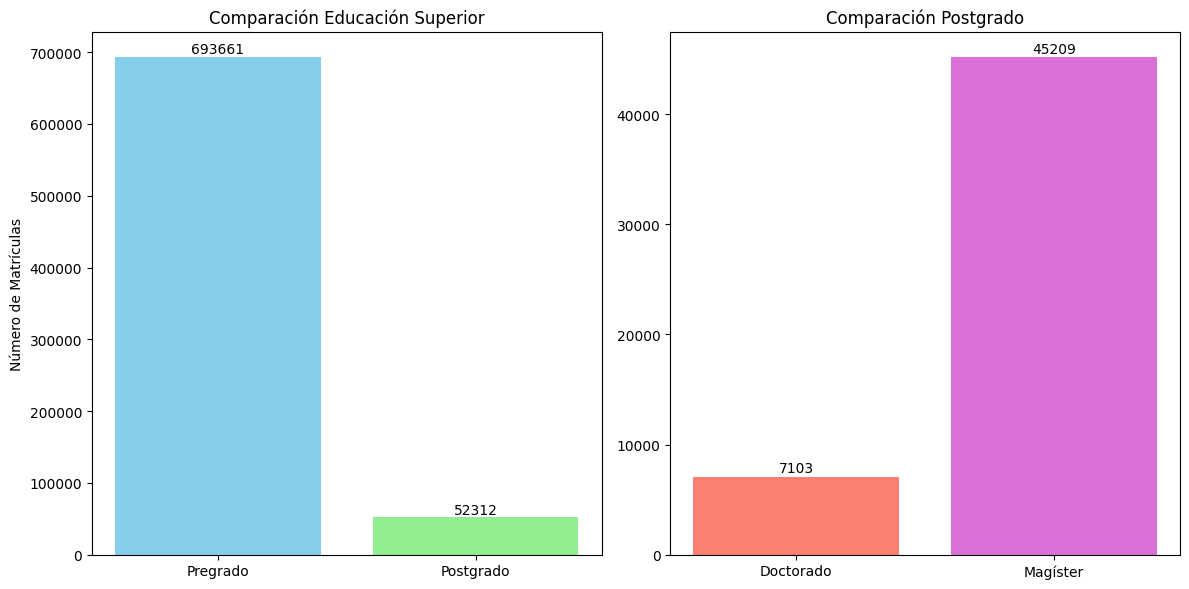

In [9]:
# Datos obtenidos de la función
matriculas_pre_post = [matricula_pregrado, matricula_postgrado]
nombres_pre_post = ['Pregrado', 'Postgrado']

matriculas_dr_mg = [matricula_Dr, matricula_Mg]
nombres_dr_mg = ['Doctorado', 'Magíster']

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Subgráfico para Pregrado vs Postgrado
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
plt.bar(nombres_pre_post, matriculas_pre_post, color=['skyblue', 'lightgreen'])
plt.title('Comparación Educación Superior')
plt.ylabel('Número de Matrículas')

# Añadir valores sobre las barras
for i, v in enumerate(matriculas_pre_post):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')

# Subgráfico para Doctorado vs Magíster
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
plt.bar(nombres_dr_mg, matriculas_dr_mg, color=['salmon', 'orchid'])
plt.title('Comparación Postgrado')

# Añadir valores sobre las barras
for i, v in enumerate(matriculas_dr_mg):
    plt.text(i, v + 100, str(v), ha='center', va='bottom')

# Ajustar layout para evitar superposición
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<a id="subseccion-5-1"></a>

## 1. **[Cantidad de programas de magíster y doctorado ofrecidos por universidades según región de sede (excluyendo la Región Metropolitana)](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/numero-de-programas-de-magister-y-doctorado-por-region)**

<a id="subseccion-5-3"></a>

## 3. **[Evolución anual de la cantidad de programas de postgrado ofrecidos por universidades en Chile, según región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-programas-de-postgrado-por-region)**

<a id="subseccion-5-4"></a>

## 4. **[Cantidad de programas de postgrado en áreas STEM por región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/porcentaje_matricula_regional_stem)**

 * **Archivo**: OFERTA_SIES_2010_AL_2024.csv
 * **Descripción**: En esta sección, se realiza la carga de un archivo CSV para convertirlo en un DataFrame. Posteriormente, se aplica un filtro para el año 2023. Mediante el uso de NumPy, se añade dos columnas adicionales llamada "AUX_REGION" y "AUX_STEM" al DataFrame. "AUX_REGION" se categoriza en base a los valores de "Región Sede  " y "AUX_STEM" se categoriza en base a los valores de "Cine-F 13 Área" insertando las nuevas columnas en las ubicaciones correspondientes a la BD con el uso de Pandas. Finalmente, se exhiben los resultados obtenidos por consola. Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice) 

In [37]:
# Leer el archivo CSV en un DataFrame de pandas
df_oferta = pd.read_csv("OFERTA_SIES_2010_AL_2024.csv", encoding='ISO-8859-1', sep=';', low_memory=False) 

# Filtra los datos para el año 2023
df_filtrado = df_oferta[(df_oferta['Año  '] == 'OFE_2023')]

# Define las columnas relevantes según los parámetros proporcionados sin el parámetro año
columnas_relevantes = [
    'Tipo Institución 1  ', 'Tipo Institución 2  ', 'Tipo Institución 3  ',
    'Región Sede  ', 'Área del conocimiento  ', 'Cine-F 97 Área', 'Cine-F 97 Subárea',
    'Área Carrera Genérica', 'Cine-F 13 Área', 'Cine-F 13 Subárea',
    'Nombre Carrera  ', 'Nombre Título  ', 'Grado Académico  ',
    'Nivel Global  ', 'Nivel Carrera  '
]

# Asegurarse de que df_oferta es una copia independiente
df_oferta = df_filtrado[columnas_relevantes].copy()

# Definir la condicion de región
condiciones_region = [ df_oferta['Región Sede  '] == 'REGION METROPOLITANA', ]

# Definir la eleccion correspondiente a la condición de región
elecciones_region = [ 'Región Metropolitana', ]

# Definir la condicion de STEM
condiciones_STEM = [
    df_oferta['Cine-F 13 Área'].isin(['Ciencias naturales, matemáticas y estadística', 'Ingeniería, Industria y Construcción', 'Tecnología de la Información y la Comunicación']),
]

# Definir la eleccion correspondiente a la condición de STEM
elecciones_STEM = [ 'STEM', ]

# Crear la nueva columna 'AUX_REGION' con np.select
df_oferta['AUX_REGION'] = np.select(condiciones_region, elecciones_region, default='Regiones distintas a Metropolitana')

# Crear la nueva columna 'AUX_STEM' con np.select
df_oferta['AUX_STEM'] = np.select(condiciones_STEM, elecciones_STEM, default='NO STEM')

# Insertar 'AUX_REGION' entre 'Región Sede' y 'Área del conocimiento'
indice_columna_region = df_oferta.columns.get_loc('Región Sede  ') + 1  # Obtener el índice de la columna después de 'Región Sede'
df_oferta.insert(indice_columna_region, 'AUX_REGION', df_oferta.pop('AUX_REGION'))  # Insertar 'AUX_REGION' en la posición deseada

# Insertar 'AUX_STEM' entre 'Cine-F 13 Área' y 'Cine-F 13 Subárea'
indice_columna_stem = df_oferta.columns.get_loc('Cine-F 13 Área') + 1  # Obtener el índice de la columna después de 'Cine-F 13 Área'
df_oferta.insert(indice_columna_stem, 'AUX_STEM', df_oferta.pop('AUX_STEM'))  # Insertar 'AUX_STEM' en la posición deseada

In [38]:
# creamos una variable nueva para que no se modifique el df de carga al usar ploteos
df_oferta_carga = df_oferta

In [39]:
# Obtener los primeros 5 resultados de df_oferta
df_oferta_ensayo = df_oferta.head()

# Mostrar los primeros 5 resultados
print(df_oferta_ensayo)
print(f'[{df_oferta.shape[0]} registros x {df_oferta.shape[1]} columnas]')

      Tipo Institución 1   Tipo Institución 2            Tipo Institución 3    \
28009        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28010        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28011        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28012        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28013        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   

              Región Sede              AUX_REGION Área del conocimiento    \
28009  REGION METROPOLITANA  Región Metropolitana                 Derecho   
28010  REGION METROPOLITANA  Región Metropolitana                 Derecho   
28011  REGION METROPOLITANA  Región Metropolitana                   Salud   
28012  REGION METROPOLITANA  Región Metropolitana              Tecnología   
28013  REGION METROPOLITANA  Región Metropolitana             Humanidades   

                                         Cine-F 97

<a id="subseccion-5-1-1"></a>

- ### **Grafica indicador 1:** [Cantidad de programas de magíster y doctorado ofrecidos por universidades según región de sede (excluyendo la Región Metropolitana)](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/numero-de-programas-de-magister-y-doctorado-por-region)

[Volver al índice](#indice) 

In [13]:
def calculo_distribucion(df):
    # Región de Arica y Parinacota
    Mg_AP = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ARICA Y PARINACOTA')])
    Dr_AP = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ARICA Y PARINACOTA')]) 
    # Región de Tarapacá
    Mg_TA = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE TARAPACA')])
    Dr_TA = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE TARAPACA')])
    # Región de Antofagasta
    Mg_AN = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ANTOFAGASTA')])
    Dr_AN = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ANTOFAGASTA')]) 
    # Región de Atacama 
    Mg_AT = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ATACAMA')])
    Dr_AT = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ATACAMA')]) 
    # Región de Coquimbo
    Mg_CO = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE COQUIMBO')])
    DR_CO = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE COQUIMBO')])
    # Región de Valparaíso
    Mg_VA = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE VALPARAISO')])
    Dr_VA = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE VALPARAISO')]) 
    # Región del Libertador General Bernardo O'Higgins
    Mg_LI = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DEL LIBERTADOR BERNARDO OHIGGINS')])
    Dr_LI = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DEL LIBERTADOR BERNARDO OHIGGINS')])
    # Región del Maule
    Mg_ML = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DEL MAULE')])
    Dr_ML = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DEL MAULE')])  
    # Región del Ñuble
    Mg_NB = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ÑUBLE')])
    Dr_NB = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE ÑUBLE')])  
    # Región del Bio Bío
    Mg_BI = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DEL BIOBIO')])
    Dr_BI = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DEL BIOBIO')]) 
    # Región de La Araucanía
    Mg_AR = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE LA ARAUCANIA')])
    Dr_AR = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE LA ARAUCANIA')]) 
    # Región de Los Ríos           
    Mg_LR = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE LOS RIOS')])
    Dr_LR = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE LOS RIOS')])  
    # Región de Los Lagos
    Mg_LL = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE LOS LAGOS')])
    Dr_LL = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE LOS LAGOS')])  
    # Región de Aysén
    Mg_AI = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO')])
    Dr_AI = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO')]) 
    # Región de Magallanes
    Mg_MA = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE MAGALLANES Y DE LA ANTARTICA CHILENA')])
    Dr_MA = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['Región Sede  '] == 'REGION DE MAGALLANES Y DE LA ANTARTICA CHILENA')])  

    return  Mg_AP, Dr_AP, Mg_TA, Dr_TA, Mg_AN, Dr_AN, Mg_AT, Dr_AT, Mg_CO, DR_CO, \
            Mg_VA, Dr_VA, Mg_LI, Dr_LI, Mg_ML, Dr_ML, Mg_NB, Dr_NB, Mg_BI, Dr_BI, \
            Mg_AR, Dr_AR, Mg_LR, Dr_LR, Mg_LL, Dr_LL, Mg_AI, Dr_AI, Mg_MA, Dr_MA

# Llamar a la función y almacenar 
Mg_AP, Dr_AP, Mg_TA, Dr_TA, Mg_AN, Dr_AN, Mg_AT, Dr_AT, Mg_CO, DR_CO, \
Mg_VA, Dr_VA, Mg_LI, Dr_LI, Mg_ML, Dr_ML, Mg_NB, Dr_NB, Mg_BI, Dr_BI, \
Mg_AR, Dr_AR, Mg_LR, Dr_LR, Mg_LL, Dr_LL, Mg_AI, Dr_AI, Mg_MA, Dr_MA = calculo_distribucion(df_oferta)

# Mostrar los resultados
print('Región de Arica y Parinacota, Doctorado: {:.0f}'.format(Mg_AP), '   Magister: {:.0f}'.format(Dr_AP))
print('Región de Tarapacá,           Doctorado: {:.0f}'.format(Mg_TA), '   Magister: {:.0f}'.format(Dr_TA))
print('Región de Antofagasta,        Doctorado: {:.0f}'.format(Mg_AN), '   Magister: {:.0f}'.format(Dr_AN))
print('Región de Atacama,            Doctorado: {:.0f}'.format(Mg_AT), '   Magister: {:.0f}'.format(Dr_AT))
print('Región de Coquimbo,           Doctorado: {:.0f}'.format(Mg_CO), '   Magister: {:.0f}'.format(DR_CO))
print('Región de Valparaíso,         Doctorado: {:.0f}'.format(Mg_VA), '  Magister: {:.0f}'.format(Dr_VA))
print('Región de OHiggins,           Doctorado: {:.0f}'.format(Mg_LI), '    Magister: {:.0f}'.format(Dr_LI))
print('Región del Maule,             Doctorado: {:.0f}'.format(Mg_ML), '   Magister: {:.0f}'.format(Dr_ML))
print('Región del Ñuble,             Doctorado: {:.0f}'.format(Mg_NB), '   Magister: {:.0f}'.format(Dr_NB))
print('Región del Bio Bío,           Doctorado: {:.0f}'.format(Mg_BI), '  Magister: {:.0f}'.format(Dr_BI))
print('Región de La Araucanía,       Doctorado: {:.0f}'.format(Mg_AR), '  Magister: {:.0f}'.format(Dr_AR))
print('Región de Los Ríos,           Doctorado: {:.0f}'.format(Mg_LR), '   Magister: {:.0f}'.format(Dr_LR))
print('Región de Los Lagos,          Doctorado: {:.0f}'.format(Mg_LL), '   Magister: {:.0f}'.format(Dr_LL))
print('Región de Aysén,              Doctorado: {:.0f}'.format(Mg_AI), '    Magister: {:.0f}'.format(Dr_AI))
print('Región de Magallanes,         Doctorado: {:.0f}'.format(Mg_MA), '    Magister: {:.0f}'.format(Dr_MA))

Región de Arica y Parinacota, Doctorado: 20    Magister: 7
Región de Tarapacá,           Doctorado: 21    Magister: 3
Región de Antofagasta,        Doctorado: 60    Magister: 16
Región de Atacama,            Doctorado: 14    Magister: 1
Región de Coquimbo,           Doctorado: 44    Magister: 10
Región de Valparaíso,         Doctorado: 193   Magister: 55
Región de OHiggins,           Doctorado: 3     Magister: 0
Región del Maule,             Doctorado: 71    Magister: 25
Región del Ñuble,             Doctorado: 34    Magister: 7
Región del Bio Bío,           Doctorado: 228   Magister: 49
Región de La Araucanía,       Doctorado: 105   Magister: 18
Región de Los Ríos,           Doctorado: 66    Magister: 19
Región de Los Lagos,          Doctorado: 66    Magister: 5
Región de Aysén,              Doctorado: 0     Magister: 0
Región de Magallanes,         Doctorado: 8     Magister: 2


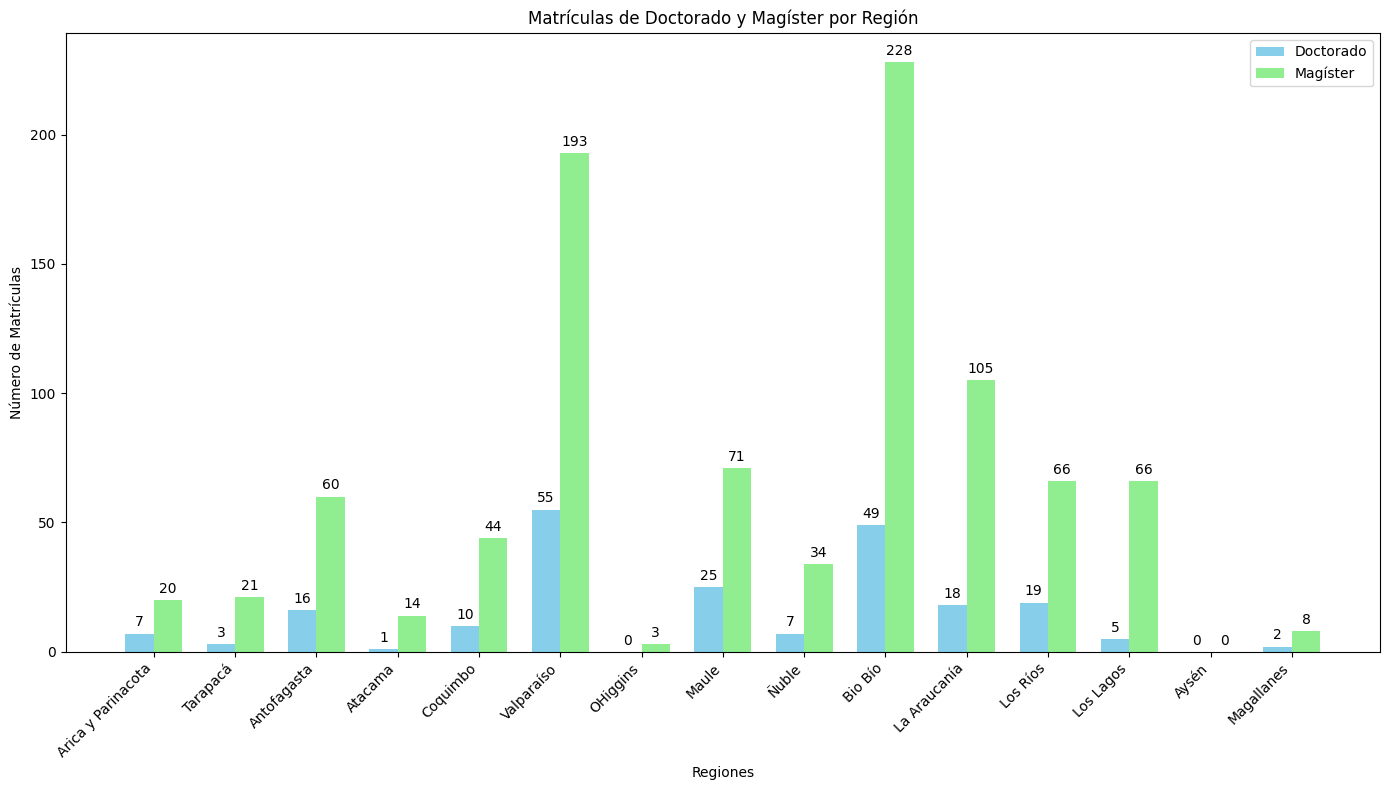

In [14]:
# Datos de matrículas obtenidos de la función
matriculas_doctorado = [Dr_AP, Dr_TA, Dr_AN, Dr_AT, DR_CO, Dr_VA, Dr_LI, Dr_ML, Dr_NB, Dr_BI, Dr_AR, Dr_LR, Dr_LL, Dr_AI, Dr_MA]
matriculas_magister = [Mg_AP, Mg_TA, Mg_AN, Mg_AT, Mg_CO, Mg_VA, Mg_LI, Mg_ML, Mg_NB, Mg_BI, Mg_AR, Mg_LR, Mg_LL, Mg_AI, Mg_MA]
regiones = ['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 'Valparaíso', 'OHiggins', 'Maule', 'Ñuble', 'Bio Bío', 'La Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén', 'Magallanes']

# Configuración del gráfico
ind = np.arange(len(regiones))  # las ubicaciones de las regiones en el eje x
width = 0.35  # ancho de las barras

fig, ax = plt.subplots(figsize=(14, 8))
barras_doctorado = ax.bar(ind - width/2, matriculas_doctorado, width, label='Doctorado', color='skyblue')
barras_magister = ax.bar(ind + width/2, matriculas_magister, width, label='Magíster', color='lightgreen')

# Añadir título y etiquetas a los ejes
ax.set_title('Matrículas de Doctorado y Magíster por Región')
ax.set_xlabel('Regiones')
ax.set_ylabel('Número de Matrículas')
ax.set_xticks(ind)
ax.set_xticklabels(regiones, rotation=45, ha='right')
ax.legend()

# Función para añadir etiquetas sobre las barras
def autolabel(barras):
    for barra in barras:
        height = barra.get_height()
        ax.annotate('{}'.format(height),
                    xy=(barra.get_x() + barra.get_width() / 2, height),
                    xytext=(0, 3),  # desplazamiento vertical de la etiqueta
                    textcoords="offset points",
                    ha='center', va='bottom')

# Aplicar etiquetas a cada grupo de barras
autolabel(barras_doctorado)
autolabel(barras_magister)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

<a id="subseccion-5-3-1"></a>

- ### **Grafica indicador 3:** [Evolución anual de la cantidad de programas de postgrado ofrecidos por universidades en Chile, según región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-programas-de-postgrado-por-region)

[Volver al índice](#indice) 

In [15]:
def calculo_distribucion(df):
    
    postgrado_RM   = len(df[(df['Tipo Institución 1  '] == 'Universidades') & (df['Nivel Global  '] == 'Postgrado') & (df['AUX_REGION'] == 'Región Metropolitana')])
    postgrado_NoRM = len(df[(df['Tipo Institución 1  '] == 'Universidades') & (df['Nivel Global  '] == 'Postgrado') & (df['AUX_REGION'] == 'Regiones distintas a Metropolitana')]) 

    return postgrado_RM, postgrado_NoRM   

# Llamar a la función y almacenar 
postgrado_RM, postgrado_NoRM = calculo_distribucion(df_oferta)

# Mostrar los resultados
print('Postgrado Región Metropolitana:               {:.0f} programas'.format(postgrado_RM))
print('Postgrado Regiones distintas a Metropolitana: {:.0f} programas'.format(postgrado_NoRM))

Postgrado Región Metropolitana:               1295 programas
Postgrado Regiones distintas a Metropolitana: 1150 programas


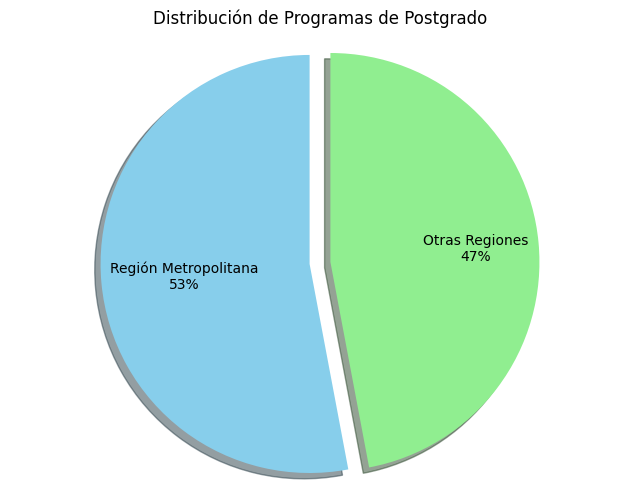

In [16]:
# Datos obtenidos de la función
tamaños = [postgrado_RM, postgrado_NoRM]
etiquetas = ['Región Metropolitana', 'Otras Regiones']
colores = ['skyblue', 'lightgreen']
explode = (0.1, 0)  # resaltar la porción

# Crear el gráfico de torta
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(tamaños, explode=explode, colors=colores, shadow=True, startangle=90)

# Añadir un título
plt.title('Distribución de Programas de Postgrado')

# Asegurar que la torta sea circular
plt.axis('equal')

# Función para calcular el porcentaje
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.0f}%'.format(pct)
    return my_format

# Colocar las etiquetas con los nombres y porcentajes en las porciones
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r * 0.7 * np.cos(np.deg2rad(angle))
    y = wedge.r * 0.7 * np.sin(np.deg2rad(angle))
    text = f"{etiquetas[i]}\n{autopct_format(tamaños)(tamaños[i]/sum(tamaños)*100)}"
    ax.annotate(text, xy=(x, y), ha='center', va='center')

# Mostrar el gráfico
plt.show()

<a id="subseccion-5-4-1"></a>

- ### **Grafica indicador 4:** [Cantidad de programas de postgrado en áreas STEM por región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/porcentaje_matricula_regional_stem)

[Volver al índice](#indice) 

In [17]:
def calculo_distribucion(df):
    # Región de Arica y Parinacota
    STEM_Mg_AP = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ARICA Y PARINACOTA')])
    STEM_Dr_AP = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ARICA Y PARINACOTA')]) 
    # Región de Tarapacá
    STEM_Mg_TA = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE TARAPACA')])
    STEM_Dr_TA = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE TARAPACA')])
    # Región de Antofagasta
    STEM_Mg_AN = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ANTOFAGASTA')])
    STEM_Dr_AN = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ANTOFAGASTA')]) 
    # Región de Atacama 
    STEM_Mg_AT = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ATACAMA')])
    STEM_Dr_AT = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ATACAMA')]) 
    # Región de Coquimbo
    STEM_Mg_CO = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE COQUIMBO')])
    STEM_DR_CO = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE COQUIMBO')])
    # Región de Valparaíso
    STEM_Mg_VA = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE VALPARAISO')])
    STEM_Dr_VA = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE VALPARAISO')]) 
    # Región del Libertador General Bernardo O'Higgins
    STEM_Mg_LI = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DEL LIBERTADOR BERNARDO OHIGGINS')])
    STEM_Dr_LI = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DEL LIBERTADOR BERNARDO OHIGGINS')])
    # Región del Maule
    STEM_Mg_ML = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DEL MAULE')])
    STEM_Dr_ML = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DEL MAULE')])  
    # Región del Ñuble
    STEM_Mg_NB = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ÑUBLE')])
    STEM_Dr_NB = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE ÑUBLE')])  
    # Región del Bio Bío
    STEM_Mg_BI = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DEL BIOBIO')])
    STEM_Dr_BI = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DEL BIOBIO')]) 
    # Región de La Araucanía
    STEM_Mg_AR = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE LA ARAUCANIA')])
    STEM_Dr_AR = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE LA ARAUCANIA')]) 
    # Región de Los Ríos           
    STEM_Mg_LR = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE LOS RIOS')])
    STEM_Dr_LR = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE LOS RIOS')])  
    # Región de Los Lagos
    STEM_Mg_LL = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE LOS LAGOS')])
    STEM_Dr_LL = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE LOS LAGOS')])  
    # Región de Aysén
    STEM_Mg_AI = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO')])
    STEM_Dr_AI = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO')]) 
    # Región de Magallanes
    STEM_Mg_MA = len(df[(df['Nivel Carrera  '] == 'Magister' ) & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE MAGALLANES Y DE LA ANTARTICA CHILENA')])
    STEM_Dr_MA = len(df[(df['Nivel Carrera  '] == 'Doctorado') & (df['Tipo Institución 1  '] == 'Universidades') & (df['AUX_STEM'] == 'STEM') & (df['Región Sede  '] == 'REGION DE MAGALLANES Y DE LA ANTARTICA CHILENA')])  

    return  STEM_Mg_AP, STEM_Dr_AP, STEM_Mg_TA, STEM_Dr_TA, STEM_Mg_AN, \
            STEM_Dr_AN, STEM_Mg_AT, STEM_Dr_AT, STEM_Mg_CO, STEM_DR_CO, \
            STEM_Mg_VA, STEM_Dr_VA, STEM_Mg_LI, STEM_Dr_LI, STEM_Mg_ML, \
            STEM_Dr_ML, STEM_Mg_NB, STEM_Dr_NB, STEM_Mg_BI, STEM_Dr_BI, \
            STEM_Mg_AR, STEM_Dr_AR, STEM_Mg_LR, STEM_Dr_LR, STEM_Mg_LL, \
            STEM_Dr_LL, STEM_Mg_AI, STEM_Dr_AI, STEM_Mg_MA, STEM_Dr_MA

# Llamar a la función y almacenar 
STEM_Mg_AP, STEM_Dr_AP, STEM_Mg_TA, STEM_Dr_TA, STEM_Mg_AN, \
STEM_Dr_AN, STEM_Mg_AT, STEM_Dr_AT, STEM_Mg_CO, STEM_DR_CO, \
STEM_Mg_VA, STEM_Dr_VA, STEM_Mg_LI, STEM_Dr_LI, STEM_Mg_ML, \
STEM_Dr_ML, STEM_Mg_NB, STEM_Dr_NB, STEM_Mg_BI, STEM_Dr_BI, \
STEM_Mg_AR, STEM_Dr_AR, STEM_Mg_LR, STEM_Dr_LR, STEM_Mg_LL, \
STEM_Dr_LL, STEM_Mg_AI, STEM_Dr_AI, STEM_Mg_MA, STEM_Dr_MA = calculo_distribucion(df_oferta)

# Mostrar los resultados
print('STEM Región de Arica y Parinacota, Doctorado: {:.0f}'.format(STEM_Mg_AP), '   Magister: {:.0f}'.format(STEM_Dr_AP))
print('STEM Región de Tarapacá,           Doctorado: {:.0f}'.format(STEM_Mg_TA), '   Magister: {:.0f}'.format(STEM_Dr_TA))
print('STEM Región de Antofagasta,        Doctorado: {:.0f}'.format(STEM_Mg_AN), '  Magister: {:.0f}'.format(STEM_Dr_AN))
print('STEM Región de Atacama,            Doctorado: {:.0f}'.format(STEM_Mg_AT), '   Magister: {:.0f}'.format(STEM_Dr_AT))
print('STEM Región de Coquimbo,           Doctorado: {:.0f}'.format(STEM_Mg_CO), '  Magister: {:.0f}'.format(STEM_DR_CO))
print('STEM Región de Valparaíso,         Doctorado: {:.0f}'.format(STEM_Mg_VA), '  Magister: {:.0f}'.format(STEM_Dr_VA))
print('STEM Región de OHiggins,           Doctorado: {:.0f}'.format(STEM_Mg_LI), '   Magister: {:.0f}'.format(STEM_Dr_LI))
print('STEM Región del Maule,             Doctorado: {:.0f}'.format(STEM_Mg_ML), '   Magister: {:.0f}'.format(STEM_Dr_ML))
print('STEM Región del Ñuble,             Doctorado: {:.0f}'.format(STEM_Mg_NB), '   Magister: {:.0f}'.format(STEM_Dr_NB))
print('STEM Región del Bio Bío,           Doctorado: {:.0f}'.format(STEM_Mg_BI), '  Magister: {:.0f}'.format(STEM_Dr_BI))
print('STEM Región de La Araucanía,       Doctorado: {:.0f}'.format(STEM_Mg_AR), '  Magister: {:.0f}'.format(STEM_Dr_AR))
print('STEM Región de Los Ríos,           Doctorado: {:.0f}'.format(STEM_Mg_LR), '  Magister: {:.0f}'.format(STEM_Dr_LR))
print('STEM Región de Los Lagos,          Doctorado: {:.0f}'.format(STEM_Mg_LL), '   Magister: {:.0f}'.format(STEM_Dr_LL))
print('STEM Región de Aysén,              Doctorado: {:.0f}'.format(STEM_Mg_AI), '   Magister: {:.0f}'.format(STEM_Dr_AI))
print('STEM Región de Magallanes,         Doctorado: {:.0f}'.format(STEM_Mg_MA), '   Magister: {:.0f}'.format(STEM_Dr_MA))

STEM Región de Arica y Parinacota, Doctorado: 3    Magister: 2
STEM Región de Tarapacá,           Doctorado: 5    Magister: 0
STEM Región de Antofagasta,        Doctorado: 26   Magister: 13
STEM Región de Atacama,            Doctorado: 4    Magister: 1
STEM Región de Coquimbo,           Doctorado: 12   Magister: 8
STEM Región de Valparaíso,         Doctorado: 63   Magister: 30
STEM Región de OHiggins,           Doctorado: 2    Magister: 0
STEM Región del Maule,             Doctorado: 8    Magister: 12
STEM Región del Ñuble,             Doctorado: 3    Magister: 3
STEM Región del Bio Bío,           Doctorado: 60   Magister: 32
STEM Región de La Araucanía,       Doctorado: 15   Magister: 6
STEM Región de Los Ríos,           Doctorado: 16   Magister: 7
STEM Región de Los Lagos,          Doctorado: 4    Magister: 2
STEM Región de Aysén,              Doctorado: 0    Magister: 0
STEM Región de Magallanes,         Doctorado: 3    Magister: 2


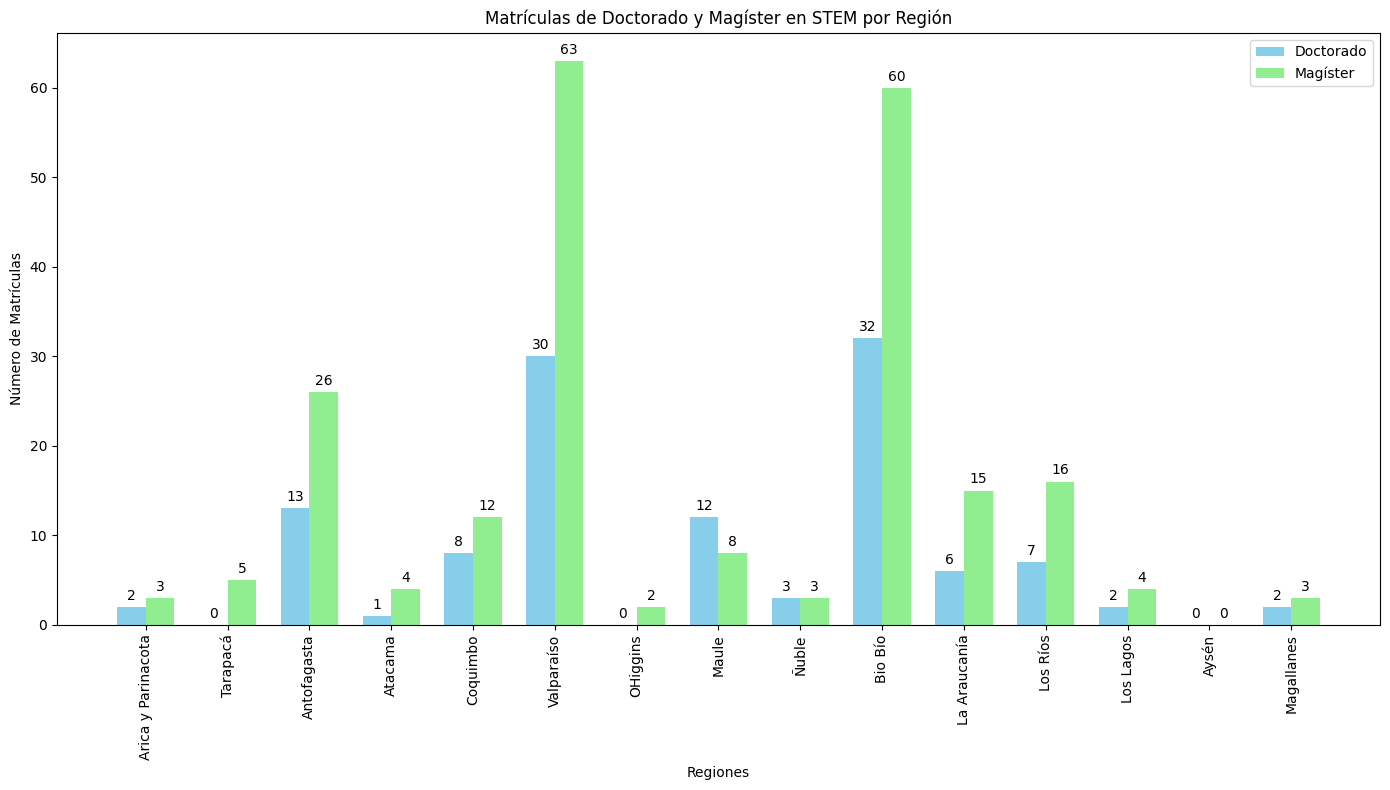

In [18]:
# Nombres de las regiones
regiones = ['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 'Valparaíso', 'OHiggins', 'Maule', 'Ñuble', 'Bio Bío', 'La Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén', 'Magallanes']

# Datos de Doctorado y Magíster en STEM por región
matriculas_doctorado = [STEM_Dr_AP, STEM_Dr_TA, STEM_Dr_AN, STEM_Dr_AT, STEM_DR_CO, STEM_Dr_VA, STEM_Dr_LI, STEM_Dr_ML, STEM_Dr_NB, STEM_Dr_BI, STEM_Dr_AR, STEM_Dr_LR, STEM_Dr_LL, STEM_Dr_AI, STEM_Dr_MA]
matriculas_magister = [STEM_Mg_AP, STEM_Mg_TA, STEM_Mg_AN, STEM_Mg_AT, STEM_Mg_CO, STEM_Mg_VA, STEM_Mg_LI, STEM_Mg_ML, STEM_Mg_NB, STEM_Mg_BI, STEM_Mg_AR, STEM_Mg_LR, STEM_Mg_LL, STEM_Mg_AI, STEM_Mg_MA]

# Configuración del gráfico
ind = np.arange(len(regiones))  # las ubicaciones de las regiones en el eje x
width = 0.35  # ancho de las barras

fig, ax = plt.subplots(figsize=(14, 8))
barras_doctorado = ax.bar(ind - width/2, matriculas_doctorado, width, label='Doctorado', color='skyblue')
barras_magister = ax.bar(ind + width/2, matriculas_magister, width, label='Magíster', color='lightgreen')

# Añadir título y etiquetas a los ejes
ax.set_title('Matrículas de Doctorado y Magíster en STEM por Región')
ax.set_xlabel('Regiones')
ax.set_ylabel('Número de Matrículas')
ax.set_xticks(ind)
ax.set_xticklabels(regiones, rotation=90)
ax.legend()

# Función para añadir etiquetas sobre las barras
def autolabel(barras):
    for barra in barras:
        height = barra.get_height()
        ax.annotate('{}'.format(height),
                    xy=(barra.get_x() + barra.get_width() / 2, height),
                    xytext=(0, 3),  # desplazamiento vertical de la etiqueta
                    textcoords="offset points",
                    ha='center', va='bottom')

# Aplicar etiquetas a cada grupo de barras
autolabel(barras_doctorado)
autolabel(barras_magister)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [19]:
# Obtener los primeros 5 resultados de df_oferta
primeros_cinco_resultados_oferta = df_oferta.head()

# Mostrar los primeros 5 resultados
print(primeros_cinco_resultados_oferta)

      Tipo Institución 1   Tipo Institución 2            Tipo Institución 3    \
28009        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28010        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28011        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28012        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   
28013        Universidades  Universidades CRUCH  Universidades Privadas CRUCH   

              Región Sede              AUX_REGION Área del conocimiento    \
28009  REGION METROPOLITANA  Región Metropolitana                 Derecho   
28010  REGION METROPOLITANA  Región Metropolitana                 Derecho   
28011  REGION METROPOLITANA  Región Metropolitana                   Salud   
28012  REGION METROPOLITANA  Región Metropolitana              Tecnología   
28013  REGION METROPOLITANA  Región Metropolitana             Humanidades   

                                         Cine-F 97

<a id="subseccion-5-5"></a>

## 5. **[Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-la-educacion-superior-respecto-al-total)**

<a id="subseccion-5-6"></a>

## 6. **[Distribución de matrículas de pregrado, magíster y doctorado según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado)**

<a id="subseccion-5-7"></a>

## 7. **[Distribución de personas matriculadas en pregrado según sexo por campo de educación.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado-por-area-de-conocimiento)**

* **Archivo**: MATRICULA_SIES_ 2007_AL_2023.csv
* **Descripción**: En esta sección, se realiza la carga de un archivo CSV para convertirlo en un DataFrame. Posteriormente, se aplica un filtro para el año 2023. Mediante el uso de NumPy, se añade una columna adicional llamada "AUX_NIVEL" al DataFrame. Esta nueva columna se categoriza en base a los valores de "CARRERA CLASIFICACIÓN NIVEL 2". Para lograr una representación detallada de los datos de matriculación, el script duplica cada fila del DataFrame resultante para separar los datos de hombres y mujeres, asignando a cada uno la cantidad correspondiente de matriculados y ajustando la categorización de sexo. Las columnas originales de matriculados por género se eliminan después de este paso para evitar redundancias. El script finaliza combinando los DataFrames de hombres y mujeres en uno solo y eliminando cualquier fila que contenga valores nulos en la columna "Matriculados", mostrando los datos procesados por consola.  Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice) 

In [34]:
# Leer el archivo CSV en un DataFrame de pandas
df_matricula = pd.read_csv("MATRICULA_SIES_ 2007_AL_2023.csv", encoding='ISO-8859-1', sep=';', low_memory=False) 

# Filtra los datos para el año 2023, excluyendo los postítulos
df_filtrado = df_matricula[(df_matricula['AÑO'] == 'MAT_2023') & (df_matricula['NIVEL GLOBAL'].isin(['Pregrado', 'Postgrado']))]

# Define las columnas relevantes según los parámetros proporcionados sin el parámetro año
columnas_relevantes = [
    'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA',
    'CINE-F 2013 ÁREA', 'CARRERA CLASIFICACIÓN NIVEL 2'
]

# Asegurarse de que df_modificacion_1 es una copia independiente
df_modificacion_1 = df_filtrado[columnas_relevantes].copy()

# Definir las condiciones
condiciones = [
    df_modificacion_1['CARRERA CLASIFICACIÓN NIVEL 2'].isin(['Carreras Profesionales', 'Carreras Técnicas']),
    df_modificacion_1['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Magister',
    df_modificacion_1['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Doctorado'
]

# Definir las elecciones correspondientes a cada condición
elecciones = [
    'Pregrado',
    'Magister',
    'Doctorado'
]

# Crear la nueva columna 
df_modificacion_1['NIVEL'] = np.select(condiciones, elecciones)

# Duplicar cada fila del DataFrame, una para Hombres y otra para Mujeres
df_hombres = df_modificacion_1.copy()
df_mujeres = df_modificacion_1.copy()

# Asignar la categoría correspondiente a la nueva columna 'Sexo'
df_hombres['Sexo'] = 'Hombres'
df_mujeres['Sexo'] = 'Mujeres'

# Asignar a cada fila la cantidad de matriculados de cada sexo 
df_hombres['Matriculados'] = df_hombres['MATRICULADOS HOMBRES POR PROGRAMA']
df_mujeres['Matriculados'] = df_mujeres['MATRICULADOS MUJERES POR PROGRAMA']

# Eliminar las columnas de matriculados por sexo, ya que no son necesarias después de asignar la 'Cantidad'
df_hombres.drop(['CARRERA CLASIFICACIÓN NIVEL 2', 'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA'], axis=1, inplace=True)
df_mujeres.drop(['CARRERA CLASIFICACIÓN NIVEL 2', 'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA'], axis=1, inplace=True)

# Combinar los DataFrames de hombres y mujeres
df_modificacion_2 = pd.concat([df_hombres, df_mujeres], ignore_index=True)

# Agrupar por las características relevantes y sumar los valores de "Matriculados"
df_modificacion_3 = df_modificacion_2.groupby(['CINE-F 2013 ÁREA', 'NIVEL', 'Sexo'], as_index=False)['Matriculados'].sum()

# Eliminar filas donde la columna "Matriculados" tenga valores nulos
df_matricula_agregada = df_modificacion_3.dropna(subset=['Matriculados'])

In [35]:
# creamos una variable nueva para que no se modifique el df de carga al usar ploteos
df_matricula_agregada_carga = df_matricula_agregada

In [36]:
# Obtener los primeros 5 resultados de df_matricula_agregada
df_matricula_agregada_ensayo = df_matricula_agregada.head()

# Mostrar los primeros 5 resultados
print(df_matricula_agregada_ensayo)
print(f'[{df_matricula_agregada.shape[0]} registros x {df_matricula_agregada.shape[1]} columnas]')

                       CINE-F 2013 ÁREA      NIVEL     Sexo  Matriculados
0  Administración de Empresas y Derecho  Doctorado  Hombres         184.0
1  Administración de Empresas y Derecho  Doctorado  Mujeres         119.0
2  Administración de Empresas y Derecho   Magister  Hombres        9215.0
3  Administración de Empresas y Derecho   Magister  Mujeres        7322.0
4  Administración de Empresas y Derecho   Pregrado  Hombres      119882.0
[60 registros x 4 columnas]


<a id="subseccion-5-5-1"></a>

- ### **Grafica del indicador del 5 :** [Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-la-educacion-superior-respecto-al-total)

[Volver al índice](#indice) 

In [23]:
def calculo_distribucion(df):
    matriculados_mujeres = df[(df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matriculados_hombres = df[(df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    total_general        = df['Matriculados'].sum()

    return  matriculados_mujeres, matriculados_hombres, total_general

# Llamar a la función y almacenar 
matriculados_mujeres, matriculados_hombres, total_general = calculo_distribucion(df_matricula_agregada)

#calculo porcentual 
por_matriculados_mujeres = (matriculados_mujeres / total_general) * 100
por_matriculados_hombres = (matriculados_hombres / total_general) * 100

# Mostrar los resultados
print('Mujeres en Educación Superior:  {:.2f}%'.format(por_matriculados_mujeres), ' Cantidad:  {:.0f} matriculados'.format(matriculados_mujeres))
print('Hombres en Educación Superior:  {:.2f}%'.format(por_matriculados_hombres), ' Cantidad:  {:.0f} matriculados'.format(matriculados_hombres))

Mujeres en Educación Superior:  53.22%  Cantidad:  692708 matriculados
Hombres en Educación Superior:  46.78%  Cantidad:  609003 matriculados


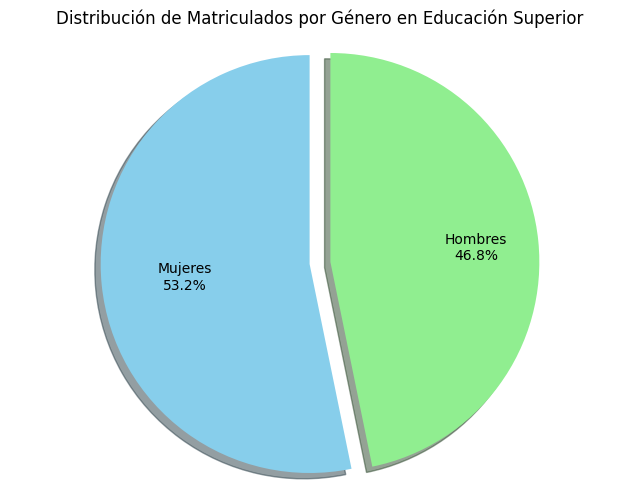

In [24]:
# Datos
etiquetas = ['Mujeres', 'Hombres']
tamaños = [matriculados_mujeres, matriculados_hombres]  # Asegúrate de definir estas variables con los datos correspondientes
colores = ['skyblue', 'lightgreen']
explode = (0.1, 0)  # resaltar la porción de mujeres

# Crear el gráfico de torta
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(tamaños, explode=explode, colors=colores, shadow=True, startangle=90)

# Añadir un título
plt.title('Distribución de Matriculados por Género en Educación Superior')

# Asegurar que la torta sea circular
plt.axis('equal')

# Función para calcular el porcentaje
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%'.format(pct)
    return my_format

# Colocar las etiquetas con los nombres y porcentajes en las porciones
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r * 0.7 * np.cos(np.deg2rad(angle))
    y = wedge.r * 0.7 * np.sin(np.deg2rad(angle))
    text = f"{etiquetas[i]}\n{autopct_format(tamaños)(tamaños[i]/sum(tamaños)*100)}"
    ax.annotate(text, xy=(x, y), ha='center', va='center')

# Mostrar el gráfico
plt.show()

<a id="subseccion-5-6-1"></a>

- ### **Grafica del indicador 6:** [Distribución de matrículas de pregrado, magíster y doctorado según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado)

[Volver al índice](#indice) 

In [25]:
def calculo_distribucion(df):
    # Gráfico Distribución de matrículas de pregrado, magíster y doctorado según sexo
    matricula_Dr_mujeres        = df[(df['NIVEL'] == 'Doctorado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_Dr_hombres        = df[(df['NIVEL'] == 'Doctorado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_Dr_total          = df[(df['NIVEL'] == 'Doctorado')]['Matriculados'].sum()

    matricula_Mg_mujeres        = df[(df['NIVEL'] == 'Magister') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_Mg_hombres        = df[(df['NIVEL'] == 'Magister') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_Mg_total          = df[(df['NIVEL'] == 'Magister')]['Matriculados'].sum()

    matricula_pregrado_mujeres  = df[(df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_pregrado_hombres  = df[(df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_pregrado_total    = df[(df['NIVEL'] == 'Pregrado')]['Matriculados'].sum()

    return  matricula_Dr_mujeres, matricula_Dr_hombres, matricula_Dr_total, \
            matricula_Mg_mujeres, matricula_Mg_hombres, matricula_Mg_total, \
            matricula_pregrado_mujeres, matricula_pregrado_hombres, matricula_pregrado_total

# Llamar a la función y almacenar 
matricula_Dr_mujeres, matricula_Dr_hombres, matricula_Dr_total, matricula_Mg_mujeres, matricula_Mg_hombres, matricula_Mg_total, matricula_pregrado_mujeres, matricula_pregrado_hombres, matricula_pregrado_total = calculo_distribucion(df_matricula_agregada)

#calculo porcentual 
por_matricula_Dr_mujeres        = (matricula_Dr_mujeres / matricula_Dr_total) * 100
por_matricula_Dr_hombres        = (matricula_Dr_hombres / matricula_Dr_total) * 100

por_matricula_Mg_mujeres        = (matricula_Mg_mujeres / matricula_Mg_total) * 100
por_matricula_Mg_hombres        = (matricula_Mg_hombres / matricula_Mg_total) * 100

por_matricula_pregrado_mujeres  = (matricula_pregrado_mujeres / matricula_pregrado_total) * 100
por_matricula_pregrado_hombres  = (matricula_pregrado_hombres / matricula_pregrado_total) * 100

# Mostrar los resultados
print('Gráfico Distribución de matrículas de pregrado, magíster y doctorado según sexo.')
print('Matrículas de Mujeres en Doctorado: {:.2f}%'.format(por_matricula_Dr_mujeres), ' Cantidad:   {:.0f} personas'.format(matricula_Dr_mujeres))
print('Matrículas de Hombres en Doctorado: {:.2f}%'.format(por_matricula_Dr_hombres), ' Cantidad:   {:.0f} personas'.format(matricula_Dr_hombres))

print('Matrículas de Mujeres en Magister:  {:.2f}%'.format(por_matricula_Mg_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_Mg_mujeres))
print('Matrículas de Hombres en Magister:  {:.2f}%'.format(por_matricula_Mg_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_Mg_hombres))

print('Matrículas de Mujeres en Pregrado:  {:.2f}%'.format(por_matricula_pregrado_mujeres), ' Cantidad: {:.0f} personas'.format(matricula_pregrado_mujeres))
print('Matrículas de Hombres en Pregrado:  {:.2f}%'.format(por_matricula_pregrado_hombres), ' Cantidad: {:.0f} personas\n'.format(matricula_pregrado_hombres))

Gráfico Distribución de matrículas de pregrado, magíster y doctorado según sexo.
Matrículas de Mujeres en Doctorado: 42.28%  Cantidad:   3003 personas
Matrículas de Hombres en Doctorado: 57.72%  Cantidad:   4100 personas
Matrículas de Mujeres en Magister:  49.92%  Cantidad:  22569 personas
Matrículas de Hombres en Magister:  50.08%  Cantidad:  22640 personas
Matrículas de Mujeres en Pregrado:  53.40%  Cantidad: 667136 personas
Matrículas de Hombres en Pregrado:  46.60%  Cantidad: 582263 personas



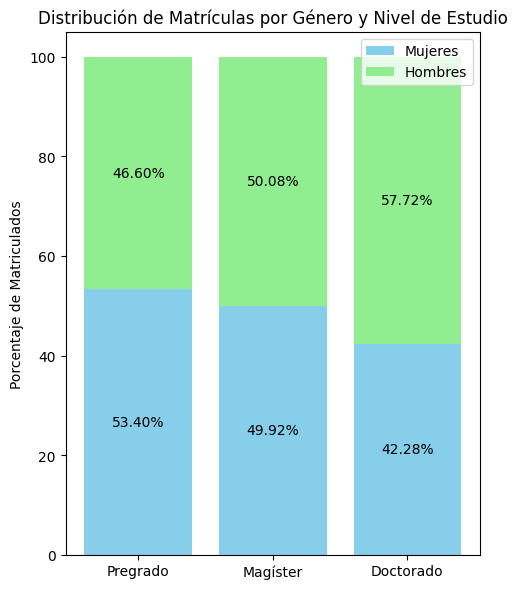

In [26]:
# Niveles de estudio
niveles_estudio = ['Pregrado', 'Magíster', 'Doctorado']

# Datos: Porcentajes de matrículas por género en cada nivel de estudio
porcentajes_mujeres = [por_matricula_pregrado_mujeres, por_matricula_Mg_mujeres, por_matricula_Dr_mujeres]
porcentajes_hombres = [por_matricula_pregrado_hombres, por_matricula_Mg_hombres, por_matricula_Dr_hombres]

x = np.arange(len(niveles_estudio))  # Ubicación de las etiquetas en el eje X

fig, ax = plt.subplots(figsize=(5, 6))

# Crear barras apiladas para mujeres
rects1 = ax.bar(x, porcentajes_mujeres, label='Mujeres', color='skyblue')

# Crear barras apiladas para hombres, comenzando donde terminan las de mujeres
rects2 = ax.bar(x, porcentajes_hombres, bottom=porcentajes_mujeres, label='Hombres', color='lightgreen')

# Añadir título y etiquetas a los ejes
ax.set_ylabel('Porcentaje de Matriculados')
ax.set_title('Distribución de Matrículas por Género y Nivel de Estudio')
ax.set_xticks(x)
ax.set_xticklabels(niveles_estudio)
ax.legend()

# Función para añadir etiquetas sobre cada barra
def autolabel(rects, labels, is_bottom):
    for rect, label in zip(rects, labels):
        if is_bottom:  # Para la sección inferior (mujeres)
            height = rect.get_height() / 2  # Colocar la etiqueta en el centro de la sección de mujeres
        else:  # Para la sección superior (hombres)
            height = rect.get_y() + rect.get_height() / 2  # Colocar la etiqueta en el centro de la sección de hombres
        ax.annotate('{:.2f}%'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # Sin offset
                    textcoords="offset points",
                    ha='center', va='center')

# Añadir etiquetas de porcentaje a las barras de mujeres
autolabel(rects1, porcentajes_mujeres, is_bottom=True)

# Añadir etiquetas de porcentaje a las barras de hombres, utilizando solo el porcentaje de hombres
autolabel(rects2, porcentajes_hombres, is_bottom=False)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

<a id="subseccion-5-7-1"></a>

- ### **Grafica del indicador 7:** [Distribución de personas matriculadas en pregrado según sexo por campo de educación.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado-por-area-de-conocimiento)

[Volver al índice](#indice)

In [27]:
def calculo_distribucion(df):
    # Administración de Empresas y Derecho
    matricula_AD_mujeres   = df[(df['CINE-F 2013 ÁREA'] == 'Administración de Empresas y Derecho') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_AD_hombres   = df[(df['CINE-F 2013 ÁREA'] == 'Administración de Empresas y Derecho') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_AD_total     = df[(df['CINE-F 2013 ÁREA'] == 'Administración de Empresas y Derecho') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Agricultura, Silvicultura, Pesca y Veterinaria
    matricula_ASPV_mujeres = df[(df['CINE-F 2013 ÁREA'] == 'Agricultura, Silvicultura, Pesca y Veterinaria') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_ASPV_hombres = df[(df['CINE-F 2013 ÁREA'] == 'Agricultura, Silvicultura, Pesca y Veterinaria') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_ASPV_total   = df[(df['CINE-F 2013 ÁREA'] == 'Agricultura, Silvicultura, Pesca y Veterinaria')]['Matriculados'].sum()
    # Artes y Humanidades
    matricula_AH_mujeres   = df[(df['CINE-F 2013 ÁREA'] == 'Artes y Humanidades') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_AH_hombres   = df[(df['CINE-F 2013 ÁREA'] == 'Artes y Humanidades') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_AH_total     = df[(df['CINE-F 2013 ÁREA'] == 'Artes y Humanidades') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Ciencias naturales, matemáticas y estadística
    matricula_CME_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias naturales, matemáticas y estadística') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_CME_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias naturales, matemáticas y estadística') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_CME_total    = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias naturales, matemáticas y estadística') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Ciencias Sociales, Periodismo e Información
    matricula_CPI_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias Sociales, Periodismo e Información') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_CPI_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias Sociales, Periodismo e Información') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_CPI_total    = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias Sociales, Periodismo e Información') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Educación
    matricula_E_mujeres    = df[(df['CINE-F 2013 ÁREA'] == 'Educación') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_E_hombres    = df[(df['CINE-F 2013 ÁREA'] == 'Educación') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_E_total      = df[(df['CINE-F 2013 ÁREA'] == 'Educación') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Ingeniaría, Industria y Construcción
    matricula_IIC_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Ingeniería, Industria y Construcción') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_IIC_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Ingeniería, Industria y Construcción') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_IIC_total    = df[(df['CINE-F 2013 ÁREA'] == 'Ingeniería, Industria y Construcción') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Salud y Bienestar
    matricula_SB_mujeres   = df[(df['CINE-F 2013 ÁREA'] == 'Salud y Bienestar') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_SB_hombres   = df[(df['CINE-F 2013 ÁREA'] == 'Salud y Bienestar') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_SB_total     = df[(df['CINE-F 2013 ÁREA'] == 'Salud y Bienestar') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Servicios
    matricula_S_mujeres    = df[(df['CINE-F 2013 ÁREA'] == 'Servicios') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_S_hombres    = df[(df['CINE-F 2013 ÁREA'] == 'Servicios') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_S_total      = df[(df['CINE-F 2013 ÁREA'] == 'Servicios') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()
    # Tecnología de la Información y la Comunicación (TIC)
    matricula_TIC_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Tecnología de la Información y la Comunicación (TIC)') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_TIC_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Tecnología de la Información y la Comunicación (TIC)') & (df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_TIC_total    = df[(df['CINE-F 2013 ÁREA'] == 'Tecnología de la Información y la Comunicación (TIC)') & (df['NIVEL'] == 'Pregrado') ]['Matriculados'].sum()

    return  matricula_AD_mujeres, matricula_AD_hombres, matricula_AD_total, \
            matricula_ASPV_mujeres, matricula_ASPV_hombres, matricula_ASPV_total, \
            matricula_AH_mujeres, matricula_AH_hombres, matricula_AH_total, \
            matricula_CME_mujeres, matricula_CME_hombres, matricula_CME_total, \
            matricula_CPI_mujeres, matricula_CPI_hombres, matricula_CPI_total, \
            matricula_E_mujeres, matricula_E_hombres, matricula_E_total, \
            matricula_IIC_mujeres, matricula_IIC_hombres, matricula_IIC_total, \
            matricula_SB_mujeres, matricula_SB_hombres, matricula_SB_total, \
            matricula_S_mujeres, matricula_S_hombres, matricula_S_total, \
            matricula_TIC_mujeres, matricula_TIC_hombres, matricula_TIC_total

# Llamar a la función y almacenar 
matricula_AD_mujeres, matricula_AD_hombres, matricula_AD_total, \
matricula_ASPV_mujeres, matricula_ASPV_hombres, matricula_ASPV_total, \
matricula_AH_mujeres, matricula_AH_hombres, matricula_AH_total, \
matricula_CME_mujeres, matricula_CME_hombres, matricula_CME_total, \
matricula_CPI_mujeres, matricula_CPI_hombres, matricula_CPI_total, \
matricula_E_mujeres, matricula_E_hombres, matricula_E_total, \
matricula_IIC_mujeres, matricula_IIC_hombres, matricula_IIC_total, \
matricula_SB_mujeres, matricula_SB_hombres, matricula_SB_total, \
matricula_S_mujeres, matricula_S_hombres, matricula_S_total, \
matricula_TIC_mujeres, matricula_TIC_hombres, matricula_TIC_total = calculo_distribucion(df_matricula_agregada)

#calculo porcentual 
por_matricula_AD_mujeres   = (matricula_AD_mujeres / matricula_AD_total) * 100
por_matricula_AD_hombres   = (matricula_AD_hombres / matricula_AD_total) * 100

por_matricula_ASPV_mujeres = (matricula_ASPV_mujeres / matricula_ASPV_total) * 100
por_matricula_ASPV_hombres = (matricula_ASPV_hombres / matricula_ASPV_total) * 100

por_matricula_AH_mujeres   = (matricula_AH_mujeres / matricula_AH_total) * 100
por_matricula_AH_hombres   = (matricula_AH_hombres / matricula_AH_total) * 100

por_matricula_CME_mujeres  = (matricula_CME_mujeres / matricula_CME_total) * 100
por_matricula_CME_hombres  = (matricula_CME_hombres / matricula_CME_total) * 100

por_matricula_CPI_mujeres  = (matricula_CPI_mujeres / matricula_CPI_total) * 100
por_matricula_CPI_hombres  = (matricula_CPI_hombres / matricula_CPI_total) * 100

por_matricula_E_mujeres    = (matricula_E_mujeres / matricula_E_total) * 100
por_matricula_E_hombres    = (matricula_E_hombres / matricula_E_total) * 100

por_matricula_IIC_mujeres  = (matricula_IIC_mujeres / matricula_IIC_total) * 100
por_matricula_IIC_hombres  = (matricula_IIC_hombres / matricula_IIC_total) * 100

por_matricula_SB_mujeres   = (matricula_SB_mujeres / matricula_SB_total) * 100
por_matricula_SB_hombres   = (matricula_SB_hombres / matricula_SB_total) * 100

por_matricula_S_mujeres    = (matricula_S_mujeres / matricula_S_total) * 100
por_matricula_S_hombres    = (matricula_S_hombres / matricula_S_total) * 100

por_matricula_TIC_mujeres  = (matricula_TIC_mujeres / matricula_TIC_total) * 100
por_matricula_TIC_hombres  = (matricula_TIC_hombres / matricula_TIC_total) * 100

total_general_mujeres = matricula_AD_mujeres+matricula_ASPV_mujeres+matricula_AH_mujeres+matricula_CME_mujeres\
                       +matricula_CPI_mujeres+matricula_E_mujeres+matricula_IIC_mujeres+matricula_SB_mujeres\
                       +matricula_S_mujeres+matricula_TIC_mujeres
total_general_hombres = matricula_AD_hombres+matricula_ASPV_hombres+matricula_AH_hombres+matricula_CME_hombres\
                       +matricula_CPI_hombres+matricula_E_hombres+matricula_IIC_hombres+matricula_SB_hombres\
                       +matricula_S_hombres+matricula_TIC_hombres
total_general = total_general_mujeres + total_general_hombres

por_total_general_mujeres = (total_general_mujeres / total_general) * 100
por_total_general_hombres = (total_general_hombres / total_general) * 100

# Mostrar los resultados
print('Cantidad de matrículas anuales de magíster y doctorado en la universidades en Chile.')
print('Matrículas de Mujeres en AD:   {:.2f}%'.format(por_matricula_AD_mujeres), ' Cantidad: {:.0f} personas'.format(matricula_AD_mujeres))
print('Matrículas de Hombres en AD:   {:.2f}%'.format(por_matricula_AD_hombres), ' Cantidad: {:.0f} personas'.format(matricula_AD_hombres))

print('Matrículas de Mujeres en ASPV: {:.2f}%'.format(por_matricula_ASPV_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_ASPV_mujeres))
print('Matrículas de Hombres en ASPV: {:.2f}%'.format(por_matricula_ASPV_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_ASPV_hombres))

print('Matrículas de Mujeres en AH:   {:.2f}%'.format(por_matricula_AH_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_AH_mujeres))
print('Matrículas de Hombres en AH:   {:.2f}%'.format(por_matricula_AH_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_AH_hombres))

print('Matrículas de Mujeres en CME:  {:.2f}%'.format(por_matricula_CME_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_CME_mujeres))
print('Matrículas de Hombres en CME:  {:.2f}%'.format(por_matricula_CME_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_CME_hombres))

print('Matrículas de Mujeres en CPI:  {:.2f}%'.format(por_matricula_CPI_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_CPI_mujeres))
print('Matrículas de Hombres en CPI:  {:.2f}%'.format(por_matricula_CPI_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_CPI_hombres))

print('Matrículas de Mujeres en E:    {:.2f}%'.format(por_matricula_E_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_E_mujeres))
print('Matrículas de Hombres en E:    {:.2f}%'.format(por_matricula_E_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_E_hombres))

print('Matrículas de Mujeres en IIC:  {:.2f}%'.format(por_matricula_IIC_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_IIC_mujeres))
print('Matrículas de Hombres en IIC:  {:.2f}%'.format(por_matricula_IIC_hombres), ' Cantidad: {:.0f} personas'.format(matricula_IIC_hombres))

print('Matrículas de Mujeres en SB:   {:.2f}%'.format(por_matricula_SB_mujeres), ' Cantidad: {:.0f} personas'.format(matricula_SB_mujeres))
print('Matrículas de Hombres en SB:   {:.2f}%'.format(por_matricula_SB_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_SB_hombres))

print('Matrículas de Mujeres en S:    {:.2f}%'.format(por_matricula_S_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_S_mujeres))
print('Matrículas de Hombres en S:    {:.2f}%'.format(por_matricula_S_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_S_hombres))

print('Matrículas de Mujeres en TIC:  {:.2f}%'.format(por_matricula_TIC_mujeres), ' Cantidad:   {:.0f} personas'.format(matricula_TIC_mujeres))
print('Matrículas de Hombres en TIC:  {:.2f}%'.format(por_matricula_TIC_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_TIC_hombres))

print('Total general de Mujeres:      {:.2f}%'.format(por_total_general_mujeres), ' Cantidad: {:.0f} personas'.format(total_general_mujeres))
print('Total general de Hombres:      {:.2f}%'.format(por_total_general_hombres), ' Cantidad: {:.0f} personas'.format(total_general_hombres))

Cantidad de matrículas anuales de magíster y doctorado en la universidades en Chile.
Matrículas de Mujeres en AD:   55.83%  Cantidad: 151555 personas
Matrículas de Hombres en AD:   44.17%  Cantidad: 119882 personas
Matrículas de Mujeres en ASPV: 59.46%  Cantidad:  24208 personas
Matrículas de Hombres en ASPV: 38.53%  Cantidad:  15684 personas
Matrículas de Mujeres en AH:   56.29%  Cantidad:  30581 personas
Matrículas de Hombres en AH:   43.71%  Cantidad:  23742 personas
Matrículas de Mujeres en CME:  44.64%  Cantidad:  11928 personas
Matrículas de Hombres en CME:  55.36%  Cantidad:  14791 personas
Matrículas de Mujeres en CPI:  65.51%  Cantidad:  44214 personas
Matrículas de Hombres en CPI:  34.49%  Cantidad:  23280 personas
Matrículas de Mujeres en E:    80.90%  Cantidad:  83401 personas
Matrículas de Hombres en E:    19.10%  Cantidad:  19685 personas
Matrículas de Mujeres en IIC:  20.98%  Cantidad:  55094 personas
Matrículas de Hombres en IIC:  79.02%  Cantidad: 207544 personas
Matrí

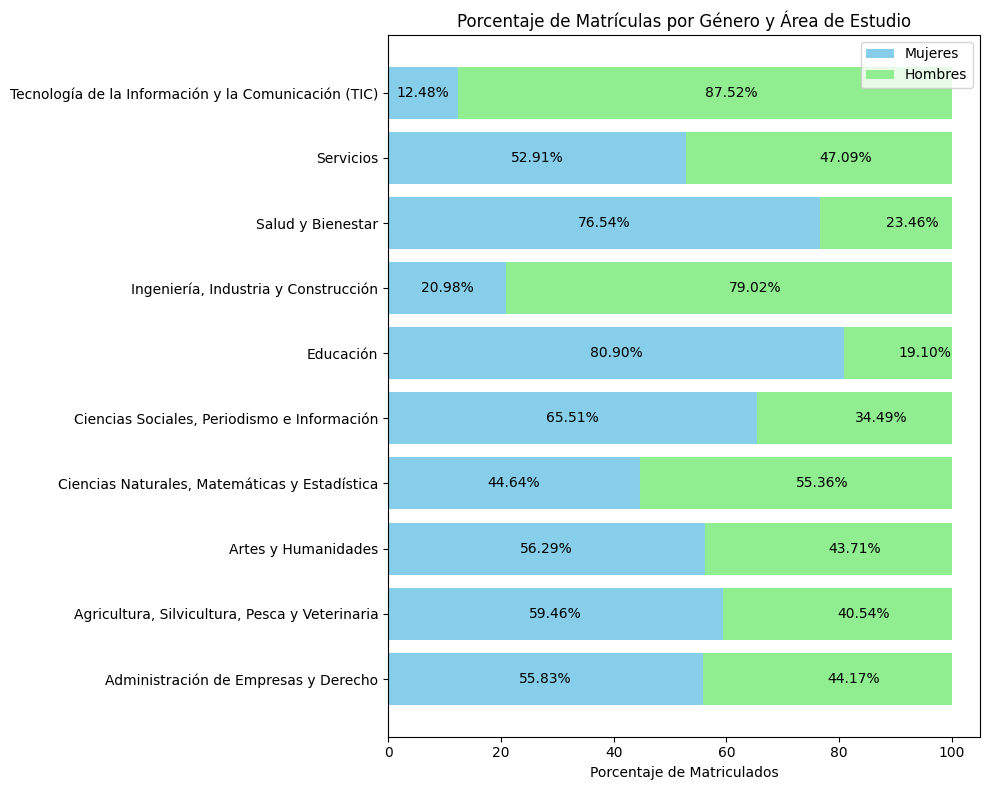

In [28]:
# Nombres de las áreas de estudio
areas_estudio = [
    'Administración de Empresas y Derecho', 
    'Agricultura, Silvicultura, Pesca y Veterinaria', 
    'Artes y Humanidades', 
    'Ciencias Naturales, Matemáticas y Estadística', 
    'Ciencias Sociales, Periodismo e Información', 
    'Educación', 
    'Ingeniería, Industria y Construcción', 
    'Salud y Bienestar', 
    'Servicios', 
    'Tecnología de la Información y la Comunicación (TIC)'
]

# Porcentajes de matrículas por género en cada área
porcentajes_mujeres = [por_matricula_AD_mujeres, por_matricula_ASPV_mujeres, por_matricula_AH_mujeres, por_matricula_CME_mujeres, por_matricula_CPI_mujeres, por_matricula_E_mujeres, por_matricula_IIC_mujeres, por_matricula_SB_mujeres, por_matricula_S_mujeres, por_matricula_TIC_mujeres]
porcentajes_hombres = [100 - pm for pm in porcentajes_mujeres]

y_pos = np.arange(len(areas_estudio))  # Ubicación de las etiquetas

fig, ax = plt.subplots(figsize=(10, 8))

# Crear barras horizontales apiladas para mujeres
rects1 = ax.barh(y_pos, porcentajes_mujeres, color='skyblue', label='Mujeres')

# Crear barras horizontales apiladas para hombres, comenzando donde terminan las de mujeres
rects2 = ax.barh(y_pos, porcentajes_hombres, left=porcentajes_mujeres, color='lightgreen', label='Hombres')

# Añadir título y etiquetas a los ejes
ax.set_yticks(y_pos)
ax.set_yticklabels(areas_estudio)
ax.set_xlabel('Porcentaje de Matriculados')
ax.set_title('Porcentaje de Matrículas por Género y Área de Estudio')
ax.legend()

# Función para añadir etiquetas sobre cada barra
def autolabel(rects, labels, xpos='inside'):
    for rect, label in zip(rects, labels):
        width = rect.get_width()
        if xpos == 'inside':
            # Mujeres
            ax.annotate('{:.2f}%'.format(label),
                        xy=(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2),
                        xytext=(0, 0),  # Sin offset
                        textcoords="offset points",
                        ha='center', va='center',
                        #color='white'  # Texto en color blanco para mejor contraste
                        )
        else:
            # Hombres
            ax.annotate('{:.2f}%'.format(label),
                        xy=(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2),
                        xytext=(0, 0),  # Offset ligero hacia la derecha
                        textcoords="offset points",
                        ha='left', va='center')

# Añadir etiquetas de porcentaje a las barras
autolabel(rects1, porcentajes_mujeres, xpos='inside')
autolabel(rects2, porcentajes_hombres, xpos='outside')

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

<a id="subseccion-5-8"></a>

## 8. **[Distribución del personal académico de las instituciones de educación superior según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-entre-el-personal-academico-de-las-instituciones-de-educacion-superior-respecto-al-total)**

 * **Archivo**: Personal_Academico_SIES_2023.xlsx
 * **Descripción**: En esta sección, se realiza la carga del archivo Excel y extrae las columnas A, C y D para convertirlo en un DataFrame. Mediante el uso de NumPy, se añade una columna adicional llamada "Tipo de institución". Esta nueva columna se categoriza en base a los valores de "Codigo IES". Para lograr una representación detallada de los datos de personal, el script duplica cada fila del DataFrame resultante para separar los datos de hombres y mujeres, asignando a cada uno la cantidad correspondiente de personal y ajustando la categorización de sexo. Las columnas originales de personal por género se eliminan después de este paso para evitar redundancias. El script finaliza combinando los DataFrames de hombres y mujeres en uno solo, mostrando los datos procesados por consola. Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice) 

In [29]:
# Abrir el archivo xlsx
personal_xlsx = openpyxl.load_workbook('Personal_Academico_SIES_2023.xlsx')

# Seleccionar la hoja 'BD_Académicos_JCE'
hoja = personal_xlsx['BD_Académicos_JCE']

# Inicializar una lista para almacenar los datos
datos = []

# Iterar sobre las filas de la hoja, empezando por la segunda para omitir el encabezado
for row in hoja.iter_rows(min_row=4):
    # Extraer los valores de las columnas A (1), B (2, asumiendo que es el nombre), C (3) y D (4)
    fila = [row[0].value, row[1].value, row[2].value, row[3].value]  # Asumiendo que B es el nombre
    datos.append(fila)

# Cerrar el archivo xlsx
personal_xlsx.close()

# Convertir los datos a un DataFrame de pandas
df_modificacion_1 = pd.DataFrame(datos, columns=['Codigo IES', 'Nombre de la institución', 'Total Mujeres', 'Total Hombres'])

# Eliminar las filas donde todas las columnas especificadas contienen NaN simultáneamente
df_modificacion_1.dropna(how='all', inplace=True)

# Definir las condiciones
condicion_cruch = df_modificacion_1['Codigo IES'].isin([3, 34, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 895, 896])
condicion_no_cruch = ~condicion_cruch & df_modificacion_1['Nombre de la institución'].str.contains('UNIVERSIDAD')

# Definir las elecciones correspondientes a cada condición
elecciones = ['CRUCH', 'NO CRUCH']

# Crear la nueva columna 'Tipo de institución'
df_modificacion_1['Tipo de institución'] = np.select([condicion_cruch, condicion_no_cruch], elecciones, default='OTRO')

# Duplicar cada fila del DataFrame, una para Hombres y otra para Mujeres
df_hombres = df_modificacion_1.copy()
df_mujeres = df_modificacion_1.copy()

# Asignar la categoría correspondiente a la nueva columna 'Sexo'
df_hombres['Sexo'] = 'Hombres'
df_mujeres['Sexo'] = 'Mujeres'

# Asignar a cada fila la cantidad de personal de cada sexo y eliminar las columnas innecesarias
df_hombres['Personal'] = df_hombres['Total Hombres']
df_mujeres['Personal'] = df_mujeres['Total Mujeres']

df_hombres.drop(['Codigo IES', 'Nombre de la institución', 'Total Mujeres', 'Total Hombres'], axis=1, inplace=True)
df_mujeres.drop(['Codigo IES', 'Nombre de la institución', 'Total Mujeres', 'Total Hombres'], axis=1, inplace=True)

# Combinar los DataFrames de hombres y mujeres
df_modificacion_2 = pd.concat([df_hombres, df_mujeres], ignore_index=True)

# Agrupar por 'Tipo de institución' y 'Sexo' y sumar la cantidad de personal
df_academicos = df_modificacion_2.groupby(['Tipo de institución', 'Sexo'])['Personal'].sum().reset_index()

# Filtrar el DataFrame para excluir filas donde el 'Tipo de institución' es 'OTRO'
df_academicos = df_academicos.query("`Tipo de institución` != 'OTRO'")

# Mostrar el DataFrame final
print(df_academicos)

  Tipo de institución     Sexo      Personal
0               CRUCH  Hombres  12549.360455
1               CRUCH  Mujeres   8623.113636
2            NO CRUCH  Hombres   7227.305631
3            NO CRUCH  Mujeres   7393.461970


In [30]:
# creamos una variable nueva para que no se modifique en los cálculos ni en los ploteos
df_academicos_carga = df_academicos

<a id="subseccion-5-8-1"></a>

- ### **Grafica del indicador 8:** [Distribución del personal académico de las instituciones de educación superior según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-entre-el-personal-academico-de-las-instituciones-de-educacion-superior-respecto-al-total)

[Volver al índice](#indice)

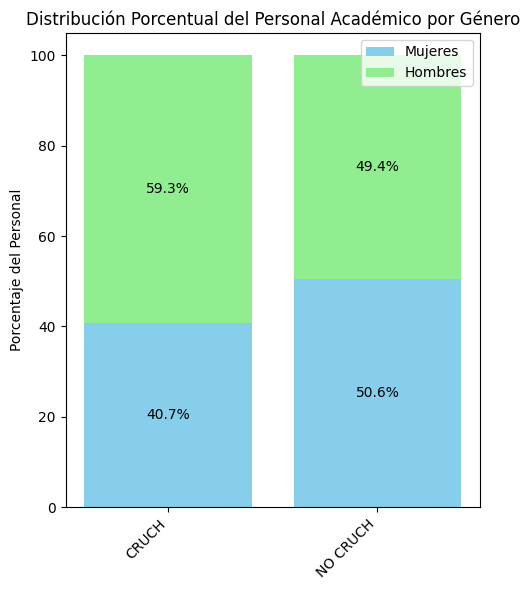

In [31]:
# Calcular el total de personal por tipo de institución
df_total_por_institucion = df_academicos.groupby('Tipo de institución')['Personal'].sum().reset_index()

# Unir el DataFrame original con los totales por tipo de institución
df_academicos = df_academicos.merge(df_total_por_institucion, on='Tipo de institución', suffixes=('', '_Total'))

# Calcular porcentajes
df_academicos['Porcentaje'] = (df_academicos['Personal'] / df_academicos['Personal_Total']) * 100

# Separar los DataFrames por género para facilitar la creación de las barras apiladas
df_mujeres = df_academicos[df_academicos['Sexo'] == 'Mujeres']
df_hombres = df_academicos[df_academicos['Sexo'] == 'Hombres']

# Nombres de las instituciones
instituciones = df_academicos['Tipo de institución'].unique()

# Ubicación de las etiquetas en el eje X
x = np.arange(len(instituciones))

fig, ax = plt.subplots(figsize=(5, 6))

# Crear barras apiladas para mujeres
rects1 = ax.bar(x, df_mujeres['Porcentaje'], label='Mujeres', color='skyblue')

# Crear barras apiladas para hombres, comenzando donde terminan las de mujeres
rects2 = ax.bar(x, df_hombres['Porcentaje'], bottom=df_mujeres['Porcentaje'].values, label='Hombres', color='lightgreen')

# Añadir título y etiquetas a los ejes
ax.set_ylabel('Porcentaje del Personal')
ax.set_title('Distribución Porcentual del Personal Académico por Género')
ax.set_xticks(x)
ax.set_xticklabels(instituciones, rotation=45, ha='right')  # Ajuste para la rotación de las etiquetas
ax.legend()

# Función para añadir etiquetas sobre cada barra
def autolabel(rects, df):
    for rect, percentage in zip(rects, df['Porcentaje']):
        height = rect.get_y() + rect.get_height() / 2  # Colocar la etiqueta en el centro de cada sección
        ax.annotate('{:.1f}%'.format(percentage),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # Sin offset
                    textcoords="offset points",
                    ha='center', va='center')

# Añadir etiquetas de porcentaje a las barras de mujeres
autolabel(rects1, df_mujeres)

# Añadir etiquetas de porcentaje a las barras de hombres, utilizando solo el porcentaje de hombres
autolabel(rects2, df_hombres)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

<a id="seccion-6"></a>

# **III) Carga**

[Volver al índice](#indice) 

In [32]:
# leer la credencial de acceso
config   = configparser.ConfigParser()
config.read('credencial_login.conf')
database = config['postgresql']['database']
user     = config['postgresql']['user']
password = config['postgresql']['password']
host     = config['postgresql']['host']
port     = config['postgresql']['port']

In [43]:
# definie y utiliza una excepción personalizada, para detener de manera limpia sin mostrar un traceback de error
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
print('El programa se detuvo para ejecutar la carga de datos por indicador.')
#pausa la ejecucióndel programa
raise StopExecution   

El programa se detuvo para ejecutar la carga de datos por indicador.


<a id="subseccion-6-2"></a>

## 2. **[Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-matricula-pregrado-magister-y-doctorado-en-universidades-en-chile)**

 * **Tabla BD:** SIES_matricula
 * modificar en variable **df_carga** de **df_matricula_ensayo** a **df_matricula_carga**

[Volver al índice](#indice)

In [ ]:
# Definimos el databrame a cargar, el de ensayo o el oficial
df_carga = df_matricula_ensayo

def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Matricula\" WHERE \"AÑO\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, df_carga):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2023'):
            for _, row in df_carga.iterrows():
                query = """
                INSERT INTO "SIES_Matricula" ("AÑO", "TOTAL MATRICULADOS", "MATRICULADOS MUJERES POR PROGRAMA", "MATRICULADOS HOMBRES POR PROGRAMA", "CLASIFICACIÓN INSTITUCIÓN NIVEL 1", "CLASIFICACIÓN INSTITUCIÓN NIVEL 2", "CLASIFICACIÓN INSTITUCIÓN NIVEL 3", "REGIÓN", "NOMBRE CARRERA", "ÁREA DEL CONOCIMIENTO", "CINE-F 1997 AREA", "CINE-F 1997 SUBAREA", "ÁREA CARRERA GENÉRICA", "CINE-F 2013 AREA", "CINE-F 2013 SUBAREA", "NIVEL GLOBAL", "CARRERA CLASIFICACIÓN NIVEL 1", "CARRERA CLASIFICACIÓN NIVEL 2", "AUX_NIVEL")
                VALUES ('2023', %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2023')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, df_carga)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada')

SyntaxError: invalid syntax (1863729684.py, line 1)

<a id="subseccion-6-1"></a>

## 1. **[Cantidad de programas de magíster y doctorado ofrecidos por universidades según región de sede (excluyendo la Región Metropolitana)](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/numero-de-programas-de-magister-y-doctorado-por-region)**

<a id="subseccion-6-3"></a>

## 3. **[Evolución anual de la cantidad de programas de postgrado ofrecidos por universidades en Chile, según región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-programas-de-postgrado-por-region)**

<a id="subseccion-6-4"></a>

## 4. **[Cantidad de programas de postgrado en áreas STEM por región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/porcentaje_matricula_regional_stem)**

 * **Tabla BD:** SIES_Oferta
 * modificar en variable **df_carga** de **df_oferta_ensayo** a **df_oferta_carga**

[Volver al índice](#indice)   

In [ ]:
# Definimos el databrame a cargar, el de ensayo o el oficial
df_carga = df_oferta_ensayo

def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Oferta\" WHERE \"Agno\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, df_carga):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2023'):
            for _, row in df_carga.iterrows():
                query = """
                INSERT INTO "SIES_Oferta" ("Agno", "Tipo Institucion 1", "Tipo Institucion 2", "Tipo Institucion 3", "Region Sede", "AUX_REGION", "Area del conocimiento", "Cine-F 97 Area", "Cine-F 97 Subarea", "Area Carrera Generica", "Cine-F 13 Area", "AUX_STEM", "Cine-F 13 Subarea", "Nombre Carrera", "Nombre Titulo", "Grado Academico", "Nivel Global", "Nivel Carrera")
                VALUES ('2023', %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2023')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, df_carga)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada')

Conexión iniciada
Datos del indicador ingresado con éxito
Conexión finalizada


<a id="subseccion-6-5"></a>

## 5. **[Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-la-educacion-superior-respecto-al-total)**

<a id="subseccion-6-6"></a>

## 6. **[Distribución de matrículas de pregrado, magíster y doctorado según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado)**

<a id="subseccion-6-7"></a>

## 7. **[Distribución de personas matriculadas en pregrado según sexo por campo de educación.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado-por-area-de-conocimiento)**

 * **Tabla BD:** SIES_Matricula_Agregada
 * modificar en variable **df_carga** de **df_matricula_agregada_ensayo** a **df_matricula_agragada_carga**  

[Volver al índice](#indice)   

In [ ]:
# Definimos el databrame a cargar, el de ensayo o el oficial
df_carga = df_matricula_agregada_ensayo

def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Matricula_Agregada\" WHERE \"Agno\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, df_carga):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2023'):
            for _, row in df_carga.iterrows():
                query = """
                INSERT INTO "SIES_Matricula_Agregada" ("Agno", "CINE F 2013", "Nivel", "Sexo", "Matriculados")
                VALUES ('2023', %s, %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2023')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, df_carga)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada')

Conexión iniciada
Datos del indicador ingresado con éxito
Conexión finalizada


<a id="subseccion-6-8"></a>

## 8. **[Distribución del personal académico de las instituciones de educación superior según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-entre-el-personal-academico-de-las-instituciones-de-educacion-superior-respecto-al-total)**

 * **Tabla BD:** SIES_Academicos

[Volver al índice](#indice) 

In [ ]:
# Definimos el databrame a cargar
df_carga = df_academicos_carga

def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Academicos\" WHERE \"Año\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, df_carga):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2023'):
            for _, row in df_carga.iterrows():
                query = """
                INSERT INTO "SIES_Academicos" ("Año", "Tipo de institución", "Sexo", "Personal")
                VALUES ('2023', %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2023')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, df_carga)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada') 

Conexión iniciada
Datos del indicador ingresado con éxito
Conexión finalizada
